In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller
* check on the limits of time between adjacent clusters, esp. when they have the same mean and/or median
    * if at $x_a$ for $t_1$ then again at $x_a$ for $t_2$, duration between going from and back to $x_a$ should reflect some mimimal amount of time ($2\times$ travel and a stay), 
        * e.g. 
            * from $x_a$ to an unknown $x_b$ with a stay at $x_b$ of the miminum duration and then back to $x_a$ 
            * should satisfy some criterion or _there is no inbetween travel and $t_1$ and $t_2$ are part of the same cluster_
* check of the metrics for inter-subcluster gaps
    * these are also clusters but unlabeled after the first round of clustering

## Notes: 

* **Gaps** 
    * since there are subclusters for a given cluster which are separated by gaps, these gaps ...

### 1-stay
* gap-merging works well when good density; poorly when otherwise

## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.



In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Sythetic data

In [8]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes

from synthetic_data.trajectory_class import get_trajectory
from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [9]:
from synthetic_data.canonical_stays import get1, get2, get3e, get3, get3_core, gen_stays

In [10]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

In [11]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev, get_boxplot_centers, get_iqr_mask

# Clustering

## Split the clusters which have a temporal gap

### IQR-plotting

For each sub-cluster, plot the quantile boxes with whistkers.

**Notes**
* the boxes usually capture the baseline of the underlying stay
* the forward and backward clusters
    * usually the same clusters in the stays with similar IQRs
    * usually different in the 

### From here

At this point, it seems that the basic clusters are formed. 

Next, use the IQRs of these clusters as the new bounds for extending the cluster: essentially using the extensible box method.

Note that the IQR can be larger than the allow distance threshold; the box would therefore need to be the smaller of the two but with the same mean and/or median

### Summary

1. `get_clusters_x` finds the clusters based on nearness of events in space and time
2. `merge_clusters` merges neraby clusters based on ...
3. `merge_clusters_2`  merges neraby clusters based on ...
4. `extend_clusters` extend the clusters
5. `separate_clusters` break the overlapping clusters and then re-merge
6. `merge_clusters_2` merge the separated clusters
7. `intersect` the forward and backward clusters

In [12]:
from helper__3stays_v3_scripts import switch_indices, get_clusters_xx, separate_clusters

In [13]:
from helper__3stays_v3_scripts__plotting import plot_cluster_boxplots

In [14]:
from helper__3stays_v3_scripts__eval import get_segments_scores

In [15]:
from helper__metric_box__explore import eval_synth_data

from helper__gaps import merge_clusters

from helper__metric_box__explore import get_cluster_boxplot, kwargs_filled, kwargs_unfilled

from helper__gaps import get_intercluster_metrics

from helper__gaps import merge_cluster_pair, gap_criterion_2, merge_clusters_2, gap_criterion_3

from helper__metric_box__explore import iqr_metrics, get_iqr, get_iqr_mask

In [16]:
from helper__3stays_v3_scripts import extend_cluster, intersecting_bounds, extend_final_clusters

from helper__3stays_v3_scripts import _extend_edge, get_iqr_mask_x, get_bounded_events, get_extended_clusters

from stay_classification.box_classifier.box_method import get_time_ind
#get_mask, make_box, get_directional_indices, get_thresh_mean, check_means, 

from helper__metric_box__explore import extend_cluster, extend_clusters, extend_edge

In [17]:
from helper__gaps import merge_clusters_combo

In [18]:
print_clusts = lambda cluster_list : [print(f"[{c[0]:4d},{c[-1]:4d}]") for c in cluster_list]
print_ctimes = lambda cluster_list : [print(f"[{time_arr[c[0]]:6.3f},{time_arr[c[-1]]:6.3f}]") for c in cluster_list]
print_ctdiff = lambda cluster_list : [print(f"{time_arr[c[-1]] - time_arr[c[0]]:6.3f}") for c in cluster_list]
print_times = lambda l: list(map(lambda x: f"{x:6.3f}",l))

In [19]:
from helper__3stays_v3_scripts import inter_bounds, contains, conta_bounds

In [27]:
def get_sorted_keys(clusts):
    d = {}
    for n, c in enumerate(clusts):
        d[n] = len(c)

    return [k for k, v in sorted(d.items(), key=lambda item: item[1])]


def check_intersecting_clusters_inds(clusters):
    m = 0
    while (m < len(clusters)):
        # Biggest cluster
        c1 = clusters[m]
        n = m+1
        while (n < len(clusters)):

            if n == m:
                n+=1
                continue

            c2 = clusters[n]
            if inter_bounds(c1,c2):
                return True, m,n
            else:
                n+=1
        m+=1
    return False, 999, 999

def check_intersecting_clusters(clusters):
    
    result, _ , _ = check_intersecting_clusters_inds(clusters)
 
    return result

def separate_clusters_hier(clusters, verbose=False):
    """
    
    Test:
    clusts = [list(range(2,4)), list(range(8)), list(range(4,8)), list(range(6,10))]
    separate_clusters_hier(clusts)
    [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
    """    
    # Check if any clusters intersect
    new_clusts = clusters.copy()
    
    result, m, n = check_intersecting_clusters_inds(new_clusts)
    
    if result:
        if verbose: print(m, n)
    else:
        return clusters

    while result:
        
        if verbose: print_clusts(new_clusts)
        if verbose: print(len(new_clusts))
        c1 = new_clusts.pop(m)
        if m < n: 
            n-=1
        c2 = new_clusts.pop(n)

        if verbose: print(len(new_clusts))
        if verbose: print(f"{m:4d}: [{c1[0]:4d},{c1[-1]:4d}] and [{c2[0]:4d},{c2[-1]:4d}]")

        '''sc1 = set(c1)
        sc2 = set(c2)

        intersexion = sc1.intersection(sc2)

        sc1_diff = sc1.difference(intersexion)
        sc2_diff = sc2.difference(intersexion)                
        '''
        
        sc1_diff, intersec, sc2_diff = split_list(c1,c2)        
        
        #sc1_diff = list(sc1_diff)
        if len(sc1_diff) > 0:
            new_clusts.append(sc1_diff)
        if verbose: print("len(sc1_diff)",len(sc1_diff))
        
        #intersexion = list(intersexion)
        if len(intersec) > 0:
            new_clusts.append(intersec)
        if verbose: print("len(intersexion)",len(intersec))
        
        #sc2_diff = list(sc2_diff)
        if len(sc2_diff) > 0:
            new_clusts.append(sc2_diff)
        if verbose: print("len(sc2_diff)",len(sc2_diff))
        
        if verbose: print(len(new_clusts))
        if verbose: print_clusts(new_clusts) 
        
        result, m, n = check_intersecting_clusters_inds(new_clusts)
        if verbose: print(result,m,n)
        if verbose: print()
        
    return new_clusts

In [34]:
from helper__gaps import merge_clusters_combo, gap_criterion

In [35]:
def split_list( l1, l2): 
    
    """
    Usage:
    split_list(range(10), list(range(4,7)))
    ([0, 1, 2, 3], [4, 5, 6], [7, 8, 9])
    """
    
    if len(l1) < len(l2):
        return ([e for e in l2 if e < min(l1)], l1, [e for e in l2 if e > max(l1)])
    else:
        return ([e for e in l1 if e < min(l2)], l2, [e for e in l1 if e > max(l2)])        

In [20]:
time_thresh = 1/6
dist_thresh=0.25

In [21]:
event_frac = 0.01 #rand_range(1,0.01,0.001)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

In [22]:
stays = get3(2, 0.5)
#stays = get1()

In [23]:
rand_range = lambda min_, max_, size: (max_-min_)*np.random.random_sample(size=size) + min_

4.5042246089701266 4.501010734335767 3.2534687872009


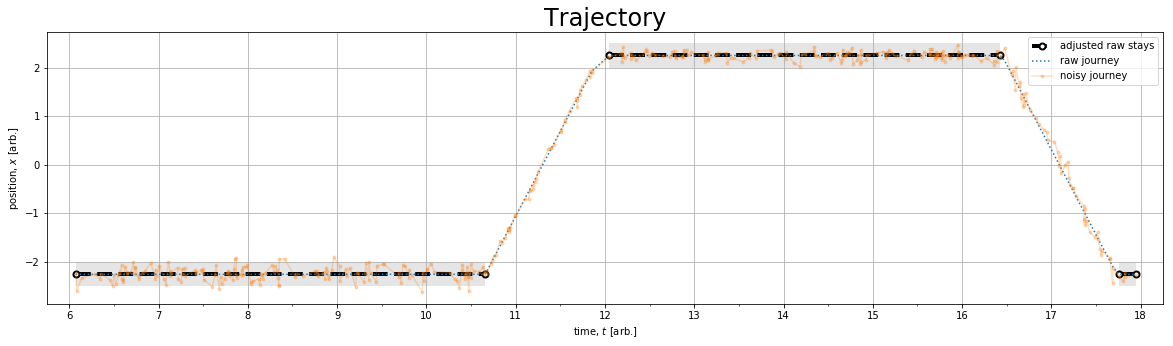

In [24]:
event_frac = rand_range(0.01,0.001, 1)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

x_dist = rand_range(0.52,5.0, 10)[0]
mid_len = rand_range(0.2, 10, 10)[0]
shift = rand_range(-10, 10, 21)[0]

print(x_dist, mid_len, shift)
if np.random.randint(0,2,1):
    stays = get3(x_dist, mid_len, shift)
else:
    stays = get3e(x_dist, mid_len, shift)    
    
continuation = True
while continuation:
    try:
        time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
        continuation = False
    except:
        pass
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, dist_thresh);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.set_xlim([5.75,18.25]);

In [36]:
verbose = True

if verbose: print(1)
time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)

if verbose: print(2)
#Here's a sticking point
# Get mini-clusters: close in space and time
clusters = get_clusters_xx(time_arr, noise_arr, dist_thresh, time_thresh)
#clusters_rev = get_clusters_xx(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)

if verbose: print(3)
#new_clusters = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
#new_clusters_rev = merge_clusters(time_arr[::-1], noise_arr[::-1], clusters_rev, dist_thresh, time_thresh)

if verbose: print(4)
# Merge neighboring clusters when they satisfy criteria --> TODO: can likely do within the first get_clusters_xx algo
new_clusters_2 = merge_clusters_combo(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
#new_clusters_rev_2 = merge_clusters_2(time_arr[::-1], noise_arr[::-1], new_clusters_rev, dist_thresh, time_thresh)

if verbose: print(5)
# Extend remaining clusters (also a merging step) and drop short clusters
ext_clusters     = get_extended_clusters(time_arr, noise_arr, new_clusters_2, time_thresh)
#ext_clusters_rev = get_extended_clusters(time_arr, noise_arr, switch_indices(new_clusters_rev_2, time_arr.shape[0]), time_thresh)

if verbose: print(6)
# Separate clusters which overlap due to last merge
ext_clusters2 = separate_clusters_hier(ext_clusters)
#ext_clusters2 = separate_clusters(ext_clusters, ext_clusters)
#ext_clusters_rev2 = separate_clusters(ext_clusters_rev, ext_clusters_rev)

if verbose: print(7)
# Merge separated neighboring clusters when they satisfy criteria
ext_clusters_2m = merge_clusters_combo(time_arr, noise_arr, ext_clusters2, dist_thresh, time_thresh)
#ext_clusters_rev_2m = merge_clusters_2(time_arr, noise_arr, ext_clusters_rev2, dist_thresh, time_thresh)

if verbose: print(8)
ext_clusters_2m = [sorted(c) for c in ext_clusters_2m]
#ext_clusters_rev_2m = [sorted(c) for c in ext_clusters_rev_2m]

1
2
3
4
5
6
7
8


`rand_range = lambda min_, max_, size: (max_-min_)*np.random.random_sample(size=size) + min_`

1
2
3
4
5
6
7
8
length 7
[   0, 141]
[ 207, 216]
[ 217, 252]
[ 260, 270]
[ 277, 289]
[ 309, 317]
[ 328, 405]
True  0.241  6.713  3.723 
 10.676

Pred  4.956  0.186  1.041  0.255  0.185  0.231  2.085 
  8.940
4.780,  137	-->	 4.765,   69
0.134,    8	-->	 0.064,    4
0.951,   34	-->	 0.844,   16
0.235,   10	-->	 0.083,    4
0.035,    6	-->	 0.002,    2
0.206,    7	-->	 0.016,    3
1.890,   71	-->	 1.849,   35


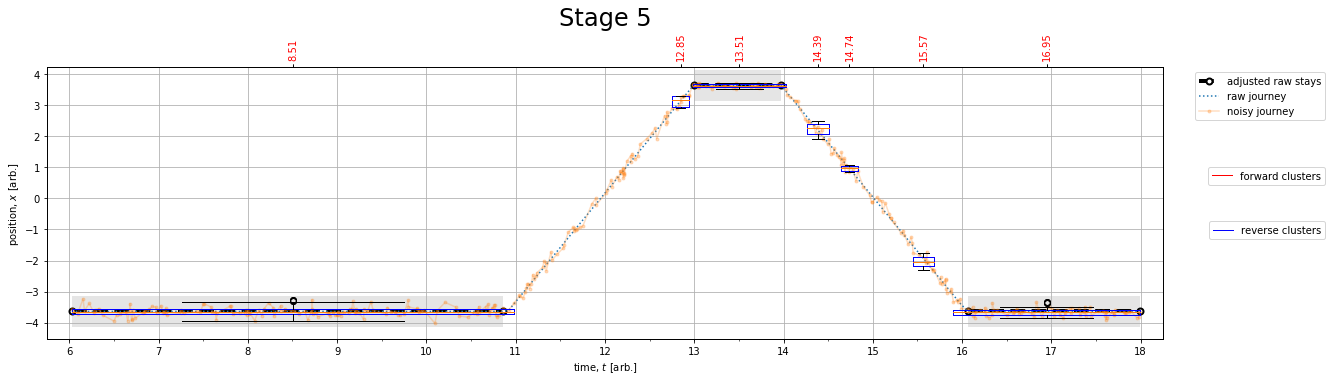

In [41]:
verbose = True

width=5
total = width*width*(2*width+1)

i = 0

length_criterion_break = False

for x_dist in rand_range(2.05*dist_thresh,11.0, width):
    for mid_len in rand_range(0.2, 10, width):
        for shift in rand_range(-10, 10, 2*width+1):

            continuation = True
            while continuation:
                
                if np.random.randint(0,2,1):
                    stays = get3(x_dist, mid_len, shift)
                else:
                    stays = get3e(x_dist, mid_len, shift)    

                try:
                    if verbose: print(1)
                    time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)

                    if verbose: print(2)
                    #Here's a sticking point
                    # Get mini-clusters: close in space and time
                    clusters = get_clusters_xx(time_arr, noise_arr, dist_thresh, time_thresh)
                    #clusters_rev = get_clusters_xx(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)

                    if verbose: print(3)
                    #new_clusters = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
                    #new_clusters_rev = merge_clusters(time_arr[::-1], noise_arr[::-1], clusters_rev, dist_thresh, time_thresh)

                    if verbose: print(4)
                    # Merge neighboring clusters when they satisfy criteria --> TODO: can likely do within the first get_clusters_xx algo
                    new_clusters_2 = merge_clusters_combo(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
                    #new_clusters_rev_2 = merge_clusters_2(time_arr[::-1], noise_arr[::-1], new_clusters_rev, dist_thresh, time_thresh)

                    if verbose: print(5)
                    # Extend remaining clusters (also a merging step) and drop short clusters
                    ext_clusters     = get_extended_clusters(time_arr, noise_arr, new_clusters_2, time_thresh)
                    #ext_clusters_rev = get_extended_clusters(time_arr, noise_arr, switch_indices(new_clusters_rev_2, time_arr.shape[0]), time_thresh)
                    
                    if verbose: print(6)
                    # Separate clusters which overlap due to last merge
                    ext_clusters2 = separate_clusters_hier(ext_clusters)
                    #ext_clusters2 = separate_clusters(ext_clusters, ext_clusters)
                    #ext_clusters_rev2 = separate_clusters(ext_clusters_rev, ext_clusters_rev)
                       
                    if verbose: print(7)
                    # Merge separated neighboring clusters when they satisfy criteria
                    ext_clusters_2m = merge_clusters_combo(time_arr, noise_arr, ext_clusters2, dist_thresh, time_thresh)
                    #ext_clusters_rev_2m = merge_clusters_2(time_arr, noise_arr, ext_clusters_rev2, dist_thresh, time_thresh)

                    if verbose: print(8)
                    ext_clusters_2m = [sorted(c) for c in ext_clusters_2m]
                    #ext_clusters_rev_2m = [sorted(c) for c in ext_clusters_rev_2m]

                    continuation = False
                except:
                    print(stays)
                    pass
                
            if check_intersecting_clusters(ext_clusters):
                print_clusts(ext_clusters)
                length_criterion_break = True
                print("clusters")
                break
                
            if len(ext_clusters_2m) != 3:
                length_criterion_break = True
                print("length",len(ext_clusters_2m))
                break
                
            prec, rec, conmat = eval_synth_data(segments, time_arr, ext_clusters_2m)
            #if verbose: print(f"{len(ext_clusters_2m):4d} clusters:", subcluster_lengths(ext_clusters_2m))
            #if verbose: print(f"\tp = {prec:6.3f}")
            #if verbose: print(f"\tr = { rec:6.3f}")
            if i % (width*width) == 0:
                print(f"{i:4d} of {total:5d}")
            i+=1

            if length_criterion_break: break
        if length_criterion_break: break
    if length_criterion_break: break

print_clusts(ext_clusters_2m)

true_durations = []
for n in range(0,len(t_segs),3):
    true_durations.append(t_segs[n+1]-t_segs[n])

pred_durations = []
for n in range(len(ext_clusters_2m)):
    pred_durations.append(time_arr[ext_clusters_2m[n][-1]]-time_arr[ext_clusters_2m[n][0]])

print("True", *print_times(true_durations), "\n", f"{sum(true_durations):6.3f}\n\nPred", *print_times(pred_durations),  "\n", f"{sum(pred_durations):6.3f}")

for c in ext_clusters_2m:
    
    c = sorted(list(set(c)))
    
    mask = get_iqr_mask(noise_arr[c], c, 1.5)
    #print(mask[0][-1])    
    #print(mask)
    #print(c)    
    ts = time_arr[mask]
    
    first = f"{ts.max()-ts.min():5.3f}, {time_arr[mask].size:4d}\t-->\t"

    mask = get_iqr_mask(noise_arr[c], c, 0.0)
    ts = time_arr[mask]    
    if mask[0].size > 0:
        second = f"{ts.max()-ts.min():5.3f}, {time_arr[mask].size:4d}"
    else:
        second = f"{0:5.3f}, {0:4d}"
    print(first,second)
    
    
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))
ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, ext_clusters_2m, switch_indices(ext_clusters_2m, time_arr.shape[0]), configs)


ax.set_ylim([noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh])
ax.set_title("Stage 5", fontsize=24);


In [306]:
get_segments_scores(time_arr, segments, ext_clusters_2m, True);

Predicted 4 of 3 true clusters 
	Cluster   0, [   0,   5]
		overlaps with 1 pred_cluster(s):
			[   0,   9]
			precision:  0.600;
			recall:  1.000

	Cluster   1, [  28, 113]
		overlaps with 1 pred_cluster(s):
			[  25, 117]
			precision:  0.925;
			recall:  1.000

	Cluster   2, [ 130, 247]
		overlaps with 1 pred_cluster(s):
			[ 130, 247]
			precision:  1.000;
			recall:  1.000

Stats: 
	min. precision:  0.600; min. recall:  1.000
	avg. precision:  0.842; avg. recall:  1.000
	tot. precision:  0.909; tot. recall:  1.000

Durations: 
tot. trajectory duration: 11.959 
tot. true stays duration: 10.182 (0.851%) 
tot. pred stays duration: 10.742 (0.898%)



### Notes
#### 3 clusters
* overlapping clusters
    * embedded and also identitcal clusters
    * **Notes**
        * usually have the same median and mean ("M&M"), but not always
    * overlap on edge between two spatially close clusters
        * maybe not sharing M&M,
    * megacluster when two clusters share an $x$ (rare)
        * should be avoidable with gap durations
* missing short clusters
    * these usually occur on the edges
    * if using a IQR-postfilter, many of these will get dropped
    
#### 4 clusters
* mis-identified cluster, aka "floater"
    * part of a travel
        * in the canonical 3-stays, these are always between larger stays
        * **Todo** 
            * _check if these have insufficient events with the IQR-mask_
            * _check if these have insufficient duration with the IQR-mask_            
    * seems to be short in duration
* overlapping clusters
    * embedded and also identitcal clusters
    * **Notes**
        * usually have the same median and mean ("M&M"), but not always
    * overlap on edge between two spatially close clusters
        * maybe not sharing M&M,
    * megacluster when two clusters share an $x$ (rare)
        * should be avoidable with gap durations
    * missing short clusters and overlaps/duplicates

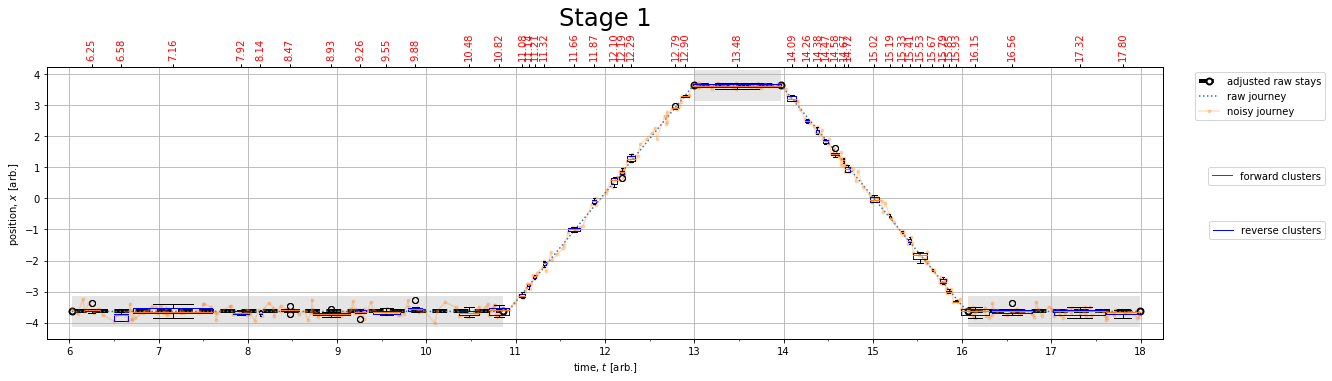

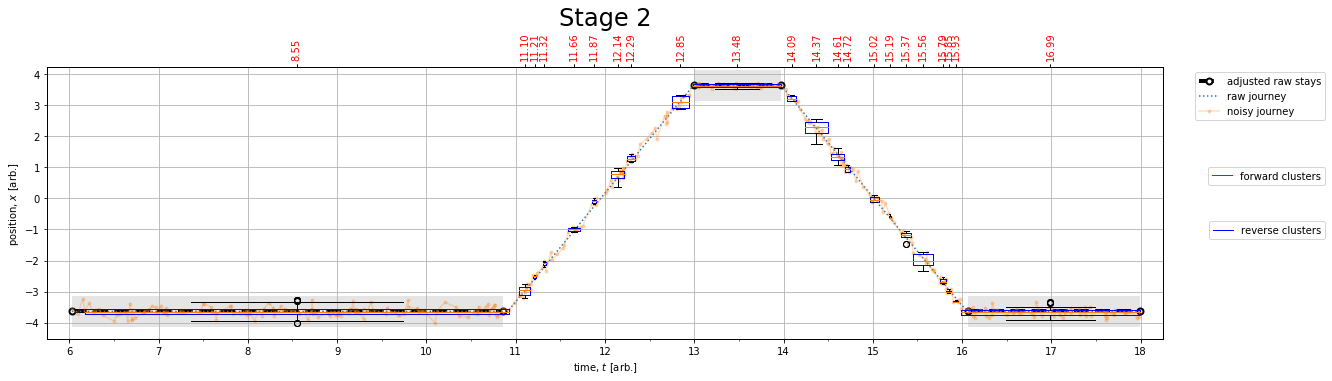

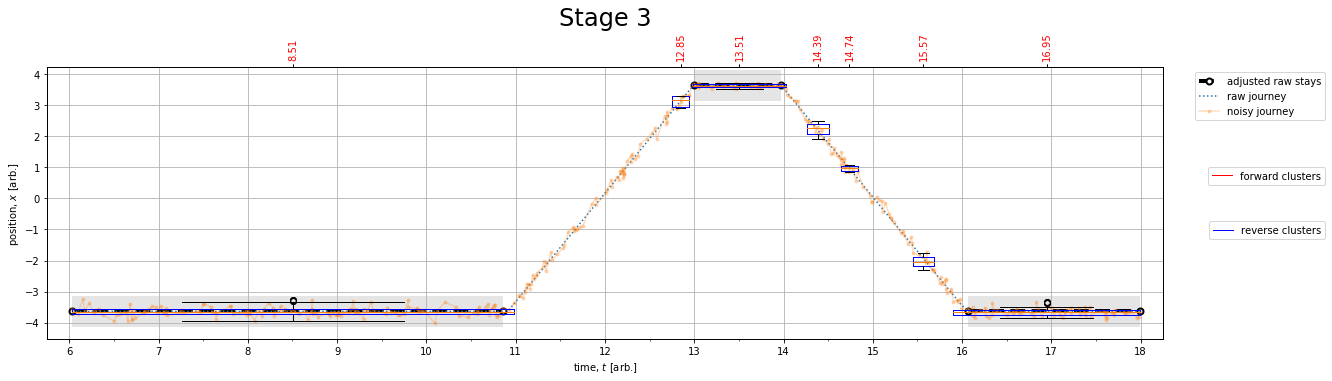

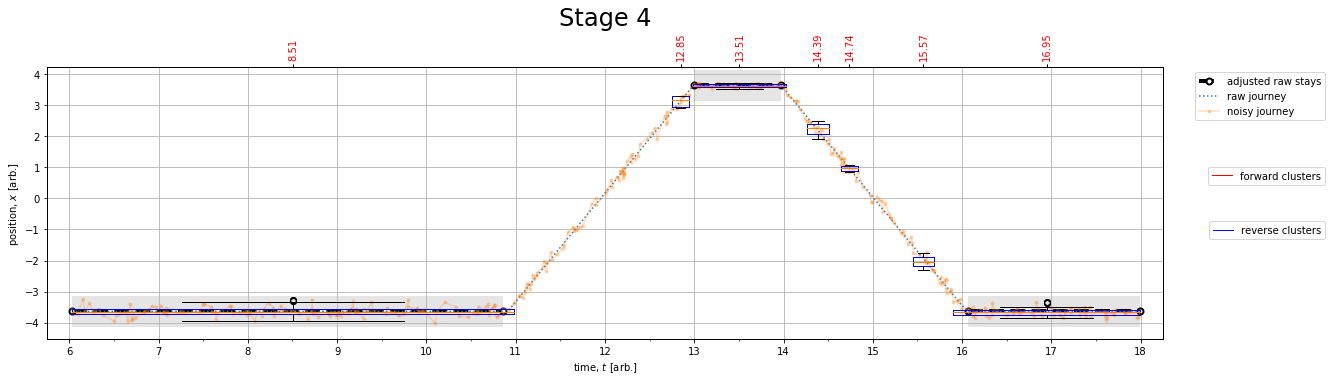

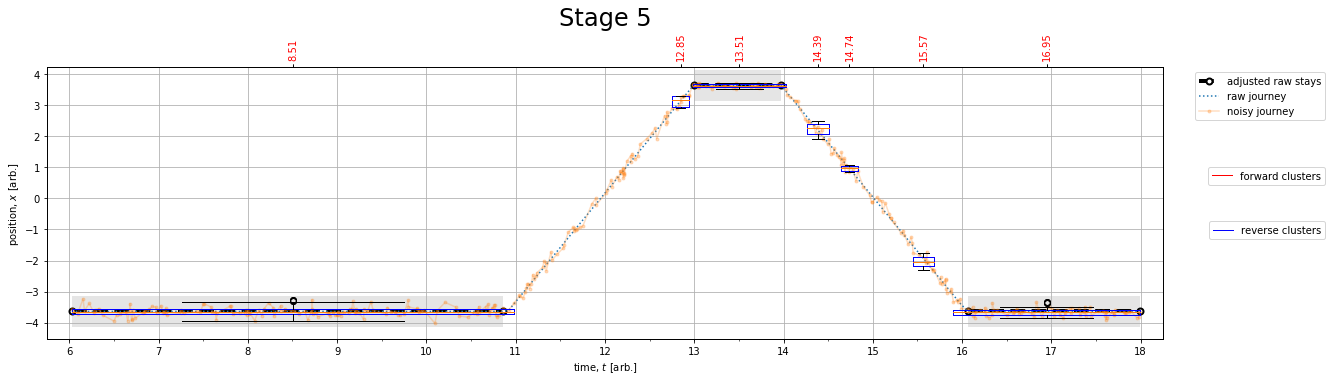

In [42]:
ylim = [noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh]


ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters, switch_indices(clusters, time_arr.shape[0]), configs)
ax.set_ylim(ylim);
ax.set_title("Stage 1", fontsize=24)

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, new_clusters_2, switch_indices(new_clusters_2, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage 2", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, ext_clusters, switch_indices(ext_clusters, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage 3", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, ext_clusters2, switch_indices(ext_clusters2, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage 4", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, ext_clusters_2m, switch_indices(ext_clusters_2m, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage 5", fontsize=24);

In [105]:
aaa = np.array([1,2,3,4])

In [111]:
aaa[2]

3

In [108]:
np.mean(np.concatenate([aaa,[1]]))

2.2

In [109]:
np.mean(np.array([1,2,3,4,1]))

2.2

In [253]:
print_clusts_2 = lambda cluster_list : [print(f"[{c[0]:4d},{c[-1]:4d}], {len(c):5d}, {time_arr[c[-1]]-time_arr[c[0]]:6.3f}") for c in cluster_list]

In [211]:
clusters_xxx = get_clusters_xxx(time_arr, noise_arr, dist_thresh, time_thresh, True)

0 21 401 402 430
0.11 406 426 21
Try  426:  err1 =  0.222, err2 =  0.000 
0.11 406 427 22
Try  427:  err1 =  0.212, err2 =  0.000 
0.11 406 428 23
Try  428:  err1 =  0.223, err2 =  0.000 
0.11 406 429 24
Try  429:  err1 =  0.217, err2 =  0.000 
2: 25
Done


In [254]:
print(len(clusters_xxx)), print_clusts_2(clusters_xxx);

21
[   1, 164],   164,  4.836
[ 166, 167],     2,  0.013
[ 175, 180],     6,  0.090
[ 183, 187],     5,  0.043
[ 191, 194],     4,  0.034
[ 202, 205],     4,  0.062
[ 209, 210],     2,  0.012
[ 212, 218],     7,  0.122
[ 220, 230],    11,  0.177
[ 232, 236],     5,  0.075
[ 239, 283],    45,  1.155
[ 287, 288],     2,  0.038
[ 292, 297],     6,  0.136
[ 300, 303],     4,  0.021
[ 309, 313],     5,  0.062
[ 315, 323],     9,  0.131
[ 325, 328],     4,  0.024
[ 332, 334],     3,  0.075
[ 336, 339],     4,  0.115
[ 345, 350],     6,  0.078
[ 353, 429],    77,  1.917


In [126]:
print(len(new_clusters_2)), print_clusts(new_clusters_2);

21
[   1, 164]
[ 166, 167]
[ 175, 180]
[ 183, 187]
[ 191, 194]
[ 202, 205]
[ 209, 210]
[ 212, 218]
[ 220, 230]
[ 232, 236]
[ 239, 283]
[ 287, 288]
[ 292, 297]
[ 300, 303]
[ 309, 313]
[ 315, 323]
[ 325, 328]
[ 332, 334]
[ 336, 339]
[ 345, 350]
[ 353, 429]


In [226]:
from helper__3stays_v3_scripts_x import get_clusters_xxx, get_clusters_xxxx

In [248]:
clusters_xxxx = get_clusters_xxxx(time_arr, noise_arr, dist_thresh, time_thresh, True);

    0,     1	Time passed
    0,     1	Dist passed:  0.034,  0.011
		Adding event
    0,     2	Time passed
    0,     2	Dist passed:  0.046,  0.011
		Adding event
    0,     3	Time passed
    0,     3	Dist passed:  0.044,  0.009
		Adding event
    0,     4	Time passed

    Closing cluster: dist. criterion failed, 4, True

	from     0,     4
		new cluster: [0, 1, 2, 3]
	  to     4,     5
    4,     5	Time passed
    4,     5	Dist passed:  0.009,  0.003
		Adding event
    4,     6	Time passed

    Closing cluster: dist. criterion failed, 2, True

	from     4,     6
		new cluster: [4, 5]
	  to     6,     7
    6,     7	Time passed

    Closing cluster: dist. criterion failed, 1, True

	from     6,     7
	  to     7,     8
    7,     8	Time passed

    Closing cluster: dist. criterion failed, 1, True

	from     7,     8
	  to     8,     9
    8,     9	Time passed
    8,     9	Dist passed:  0.151,  0.050
		Adding event
    8,    10	Time passed
    8,    10	Dist passed:  0.218,  0.055
		Addin

  340,   341	Time passed

    Closing cluster: dist. criterion failed, 1, True

	from   340,   341
	  to   341,   342
  341,   342	Time passed
  341,   342	Dist passed:  0.051,  0.017
		Adding event
  341,   343	Time passed

    Closing cluster: dist. criterion failed, 2, True

	from   341,   343
		new cluster: [341, 342]
	  to   343,   344
  343,   344	Time passed

    Closing cluster: dist. criterion failed, 1, True

	from   343,   344
	  to   344,   345
  344,   345	Time passed
  344,   345	Dist passed:  0.030,  0.010
		Adding event
  344,   346	Time passed
  344,   346	Dist passed:  0.106,  0.026
		Adding event
  344,   347	Time passed
  344,   347	Dist passed:  0.024,  0.005
		Adding event
  344,   348	Time passed

    Closing cluster: dist. criterion failed, 4, True

	from   344,   348
		new cluster: [344, 345, 346, 347]
	  to   348,   349
  348,   349	Time passed
  348,   349	Dist passed:  0.082,  0.027
		Adding event
  348,   350	Time passed
  348,   350	Dist passed:  0.036,  0

In [255]:
print(len(clusters_xxxx)), print_clusts_2(clusters_xxxx);

25
[   0, 164],   165,  4.900
[ 165, 167],     3,  0.039
[ 172, 180],     9,  0.201
[ 182, 189],     8,  0.188
[ 190, 196],     7,  0.154
[ 197, 198],     2,  0.085
[ 199, 205],     7,  0.246
[ 206, 210],     5,  0.087
[ 211, 218],     8,  0.165
[ 219, 230],    12,  0.207
[ 231, 236],     6,  0.105
[ 238, 285],    48,  1.203
[ 286, 288],     3,  0.043
[ 291, 293],     3,  0.070
[ 294, 297],     4,  0.021
[ 299, 305],     7,  0.123
[ 308, 313],     6,  0.125
[ 314, 318],     5,  0.109
[ 319, 323],     5,  0.030
[ 324, 330],     7,  0.128
[ 331, 334],     4,  0.081
[ 335, 339],     5,  0.154
[ 341, 342],     2,  0.060
[ 344, 350],     7,  0.099
[ 352, 426],    75,  1.806


In [230]:
clusters_xxx = get_clusters_xxx(time_arr, noise_arr, dist_thresh, time_thresh, True);

0 21 401 402 430
0.11 406 426 21
Try  426:  err1 =  0.222, err2 =  0.000 
0.11 406 427 22
Try  427:  err1 =  0.212, err2 =  0.000 
0.11 406 428 23
Try  428:  err1 =  0.223, err2 =  0.000 
0.11 406 429 24
Try  429:  err1 =  0.217, err2 =  0.000 
2: 25
Done


In [231]:
print(len(clusters_xxx)), print_clusts(clusters_xxx);

21
[   1, 164]
[ 166, 167]
[ 175, 180]
[ 183, 187]
[ 191, 194]
[ 202, 205]
[ 209, 210]
[ 212, 218]
[ 220, 230]
[ 232, 236]
[ 239, 283]
[ 287, 288]
[ 292, 297]
[ 300, 303]
[ 309, 313]
[ 315, 323]
[ 325, 328]
[ 332, 334]
[ 336, 339]
[ 345, 350]
[ 353, 429]


In [216]:
print(len(new_clusters_2)), print_clusts(new_clusters_2);

21
[   1, 164]
[ 166, 167]
[ 175, 180]
[ 183, 187]
[ 191, 194]
[ 202, 205]
[ 209, 210]
[ 212, 218]
[ 220, 230]
[ 232, 236]
[ 239, 283]
[ 287, 288]
[ 292, 297]
[ 300, 303]
[ 309, 313]
[ 315, 323]
[ 325, 328]
[ 332, 334]
[ 336, 339]
[ 345, 350]
[ 353, 429]


In [291]:
from helper__3stays_v3_scripts import get_clusters_x

In [308]:
clusters_x = get_clusters_x(time_arr, noise_arr, dist_thresh, time_thresh, False);

111 122 cont


In [312]:
clusters_x = merge_clusters_combo(time_arr, noise_arr, clusters_x, dist_thresh, time_thresh, False)
print(len(clusters_x)), print_clusts((clusters_x));

22
[   0, 164]
[ 166, 168]
[ 172, 181]
[ 183, 187]
[ 189, 196]
[ 202, 205]
[ 207, 210]
[ 212, 216]
[ 220, 226]
[ 228, 236]
[ 238, 283]
[ 287, 288]
[ 292, 298]
[ 300, 306]
[ 308, 313]
[ 315, 323]
[ 325, 328]
[ 332, 334]
[ 336, 339]
[ 341, 342]
[ 344, 350]
[ 352, 425]


In [276]:
drop_clusters = lambda clusters: [ c for c in clusters if abs(time_arr[c[-1]]-time_arr[c[0]]) > time_thresh]

In [277]:
print_clusts_2(clusters_xxxx);

[   0, 164],   165,  4.900
[ 165, 167],     3,  0.039
[ 172, 180],     9,  0.201
[ 182, 189],     8,  0.188
[ 190, 196],     7,  0.154
[ 197, 198],     2,  0.085
[ 199, 205],     7,  0.246
[ 206, 210],     5,  0.087
[ 211, 218],     8,  0.165
[ 219, 230],    12,  0.207
[ 231, 236],     6,  0.105
[ 238, 285],    48,  1.203
[ 286, 288],     3,  0.043
[ 291, 293],     3,  0.070
[ 294, 297],     4,  0.021
[ 299, 305],     7,  0.123
[ 308, 313],     6,  0.125
[ 314, 318],     5,  0.109
[ 319, 323],     5,  0.030
[ 324, 330],     7,  0.128
[ 331, 334],     4,  0.081
[ 335, 339],     5,  0.154
[ 341, 342],     2,  0.060
[ 344, 350],     7,  0.099
[ 352, 426],    75,  1.806


In [279]:
print_clusts_2(drop_clusters(clusters_xxxx));

[   0, 164],   165,  4.900
[ 172, 180],     9,  0.201
[ 182, 189],     8,  0.188
[ 199, 205],     7,  0.246
[ 219, 230],    12,  0.207
[ 238, 285],    48,  1.203
[ 352, 426],    75,  1.806


In [280]:
ext_clusters     = get_extended_clusters(time_arr, noise_arr, drop_clusters(new_clusters_2), time_thresh)
ext_clusters2 = separate_clusters_hier(ext_clusters)
ext_clusters_2m = merge_clusters_combo(time_arr, noise_arr, ext_clusters2, dist_thresh, time_thresh)
#ext_clusters_rev_2m = merge_clusters_2(time_arr, noise_arr, ext_clusters_rev2, dist_thresh, time_thresh)

print(len(ext_clusters_2m)), print_clusts_2(ext_clusters_2m);

4
[   0, 168],   167,  4.959
[ 220, 231],    10,  0.190
[ 239, 284],    44,  1.190
[ 352, 429],    76,  1.978


In [288]:
ext_clusters     = get_extended_clusters(time_arr, noise_arr, clusters_xxxx, time_thresh)
ext_clusters2 = separate_clusters_hier(ext_clusters)
ext_clusters_2m = merge_clusters_combo(time_arr, noise_arr, ext_clusters2, dist_thresh, time_thresh)
#ext_clusters_rev_2m = merge_clusters_2(time_arr, noise_arr, ext_clusters_rev2, dist_thresh, time_thresh)

print(len(ext_clusters_2m)), print_clusts_2(ext_clusters_2m);

6
[ 173, 181],     8,  0.181
[ 220, 231],    11,  0.190
[ 238, 286],    47,  1.285
[ 332, 338],     6,  0.220
[ 352, 429],    76,  1.978
[   0, 168],   115,  4.959


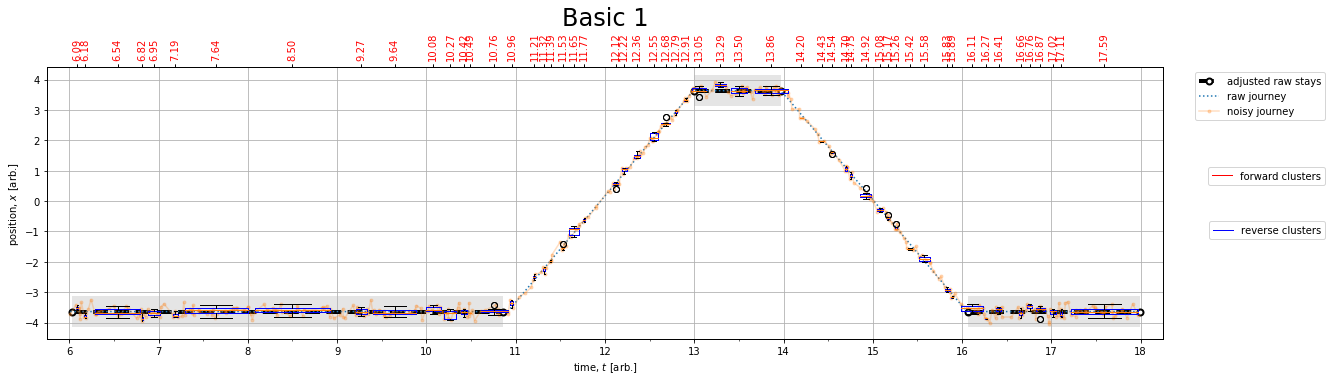

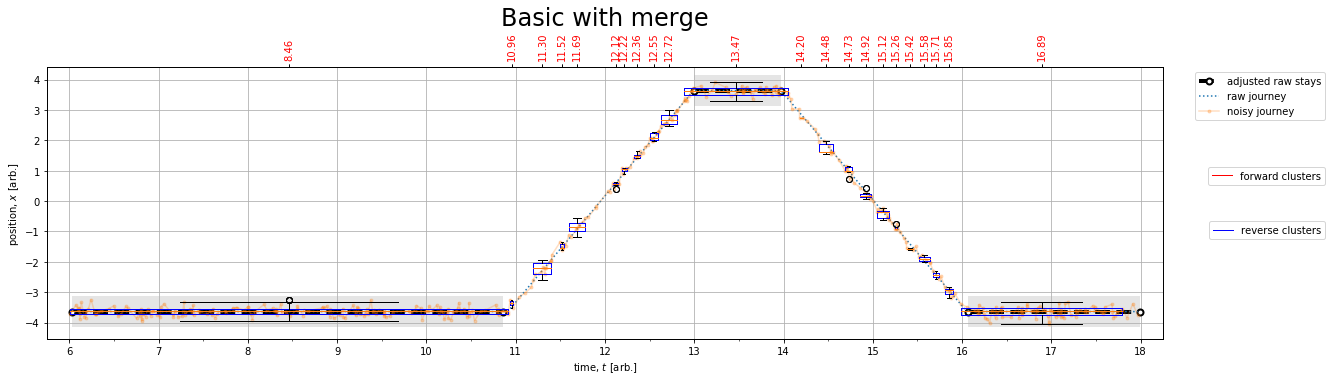

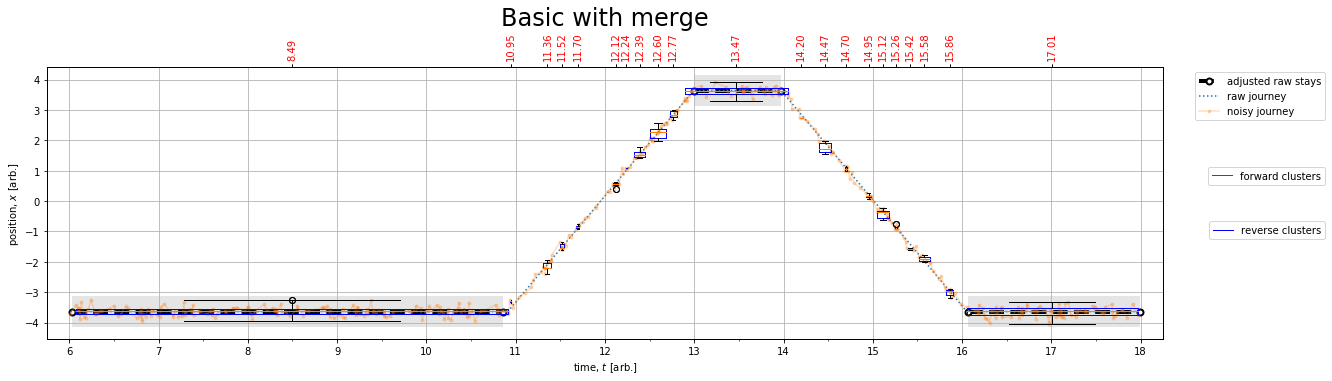

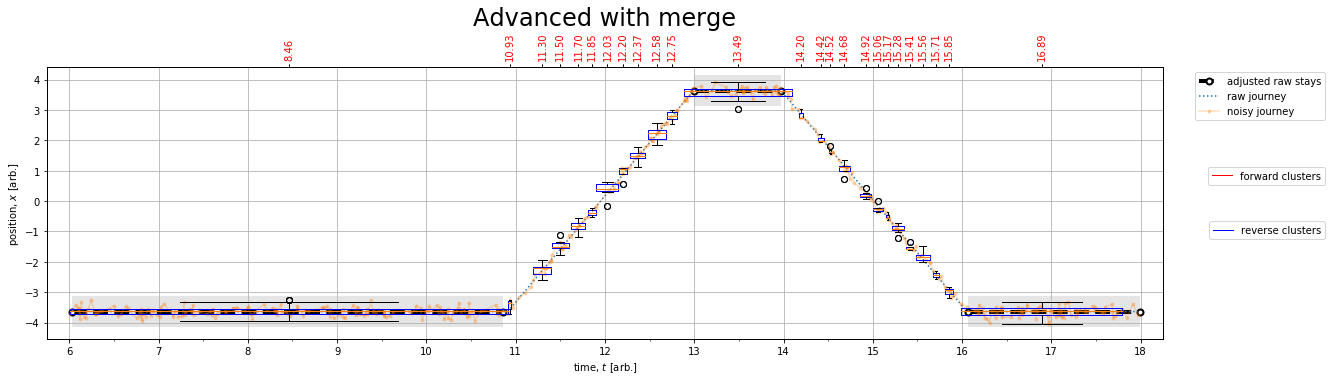

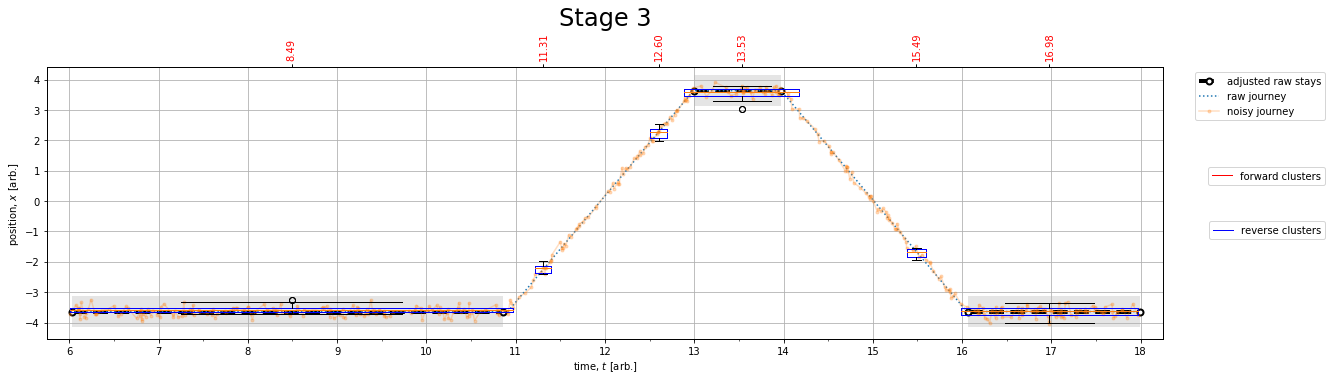

In [313]:
ylim = [noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh]


ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters, switch_indices(clusters, time_arr.shape[0]), configs)
ax.set_ylim(ylim);
ax.set_title("Basic 1", fontsize=24)

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_x, switch_indices(clusters_x, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Basic with post merge", fontsize=24);


ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_xxx, switch_indices(clusters_xxx, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Basic with integrated merge", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_xxxx, switch_indices(clusters_xxxx, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Advanced with merge", fontsize=24);


ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, ext_clusters_2m, switch_indices(ext_clusters_2m, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage 3", fontsize=24);

In [97]:
verbose = True

if verbose: print(2)
#Here's a sticking point
# Get mini-clusters: close in space and time
clusters = get_clusters_xx(time_arr, noise_arr, dist_thresh, time_thresh)
#clusters_rev = get_clusters_xx(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)

if verbose: print(3)
#new_clusters = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
#new_clusters_rev = merge_clusters(time_arr[::-1], noise_arr[::-1], clusters_rev, dist_thresh, time_thresh)

if verbose: print(4)
# Merge neighboring clusters when they satisfy criteria --> TODO: can likely do within the first get_clusters_xx algo
new_clusters_2 = merge_clusters_combo(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
#new_clusters_rev_2 = merge_clusters_2(time_arr[::-1], noise_arr[::-1], new_clusters_rev, dist_thresh, time_thresh)

new_clusters_2 = get_clusters_xxx(time_arr, noise_arr, dist_thresh, time_thresh)

if verbose: print(5)
# Extend remaining clusters (also a merging step) and drop short clusters
ext_clusters     = get_extended_clusters(time_arr, noise_arr, new_clusters_2, time_thresh)
#ext_clusters_rev = get_extended_clusters(time_arr, noise_arr, switch_indices(new_clusters_rev_2, time_arr.shape[0]), time_thresh)

if verbose: print(6)
# Separate clusters which overlap due to last merge
ext_clusters2 = separate_clusters_hier(ext_clusters)
#ext_clusters2 = separate_clusters(ext_clusters, ext_clusters)
#ext_clusters_rev2 = separate_clusters(ext_clusters_rev, ext_clusters_rev)

if verbose: print(7)
# Merge separated neighboring clusters when they satisfy criteria
ext_clusters_2m = merge_clusters_combo(time_arr, noise_arr, ext_clusters2, dist_thresh, time_thresh)
#ext_clusters_rev_2m = merge_clusters_2(time_arr, noise_arr, ext_clusters_rev2, dist_thresh, time_thresh)

if verbose: print(8)
ext_clusters_2m = [sorted(c) for c in ext_clusters_2m]
#ext_clusters_rev_2m = [sorted(c) for c in ext_clusters_rev_2m]

2
3
4
0 21 401 402 430
0.11 406 426 21
0.11 406 427 22
0.11 406 428 23
0.11 406 429 24
2 25
5
6
7
8


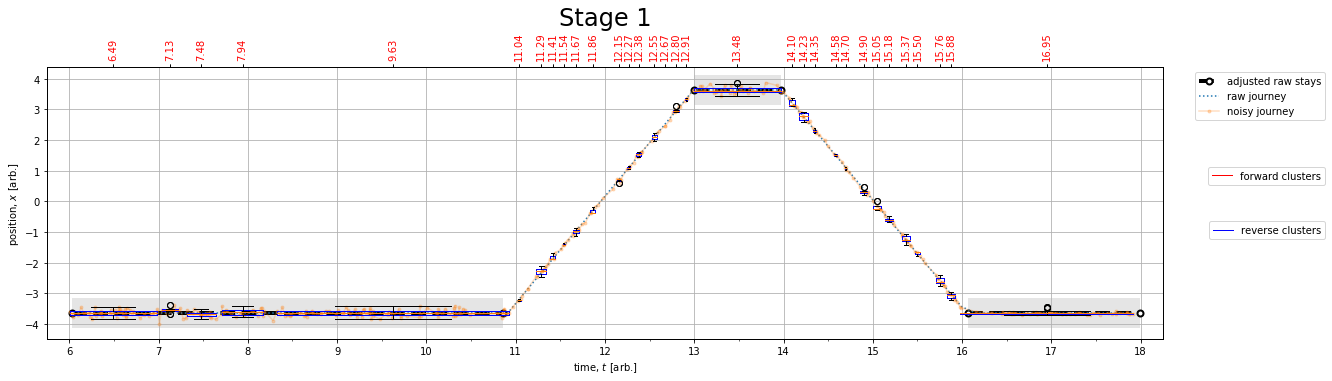

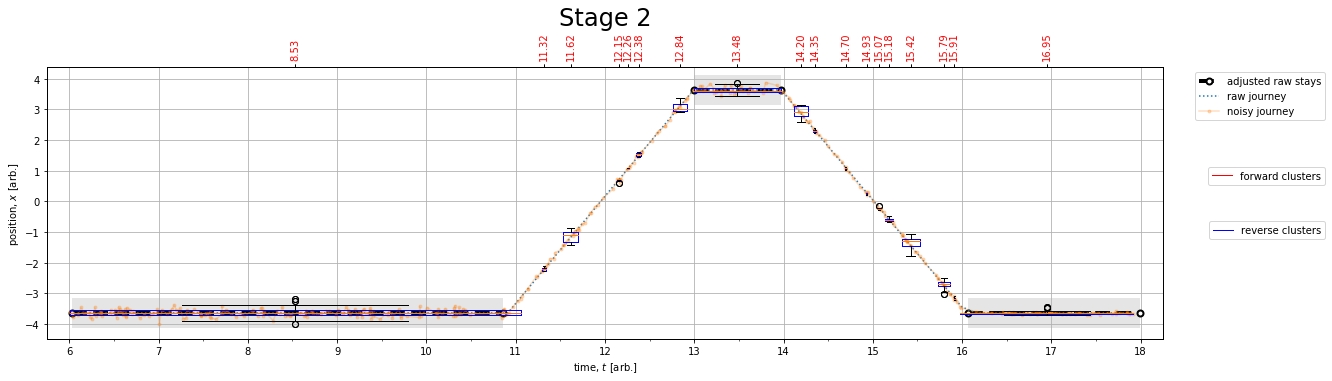

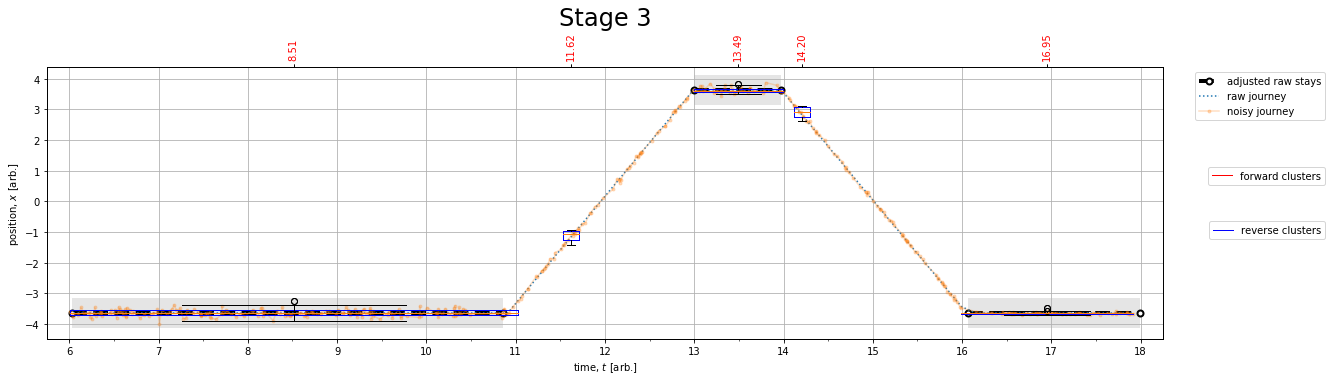

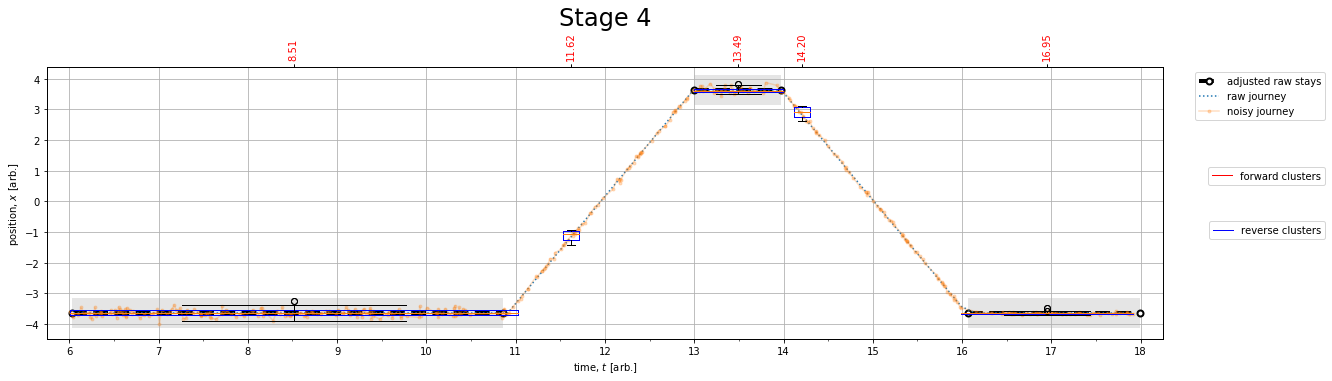

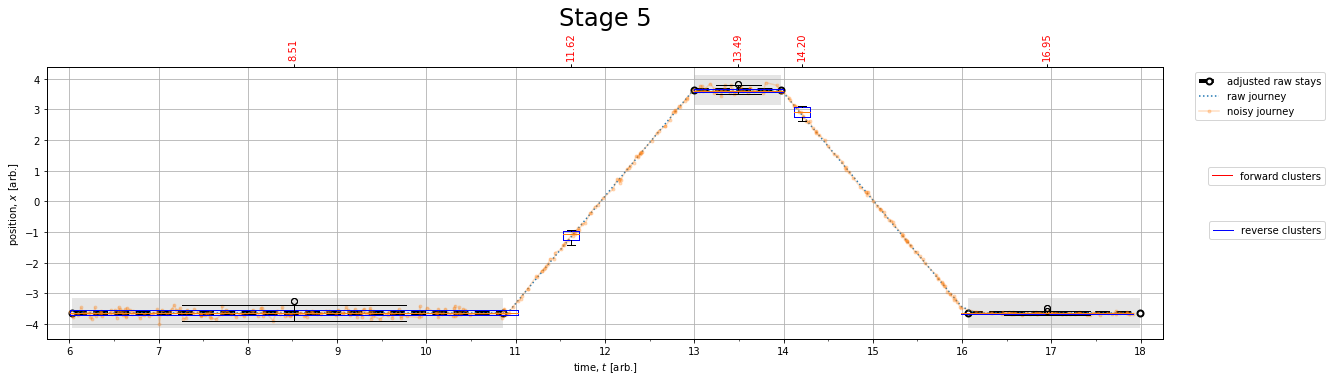

In [79]:
ylim = [noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh]


ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters, switch_indices(clusters, time_arr.shape[0]), configs)
ax.set_ylim(ylim);
ax.set_title("Stage 1", fontsize=24)

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, new_clusters_2, switch_indices(new_clusters_2, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage 2", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, ext_clusters, switch_indices(ext_clusters, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage 3", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, ext_clusters2, switch_indices(ext_clusters2, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage 4", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, ext_clusters_2m, switch_indices(ext_clusters_2m, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage 5", fontsize=24);

In [ ]:
width=5
total = width*width*(2*width+1)

i = 0

length_criterion_break = False

for x_dist in rand_range(0.52,5.0, width):
    for mid_len in rand_range(0.2, 10, width):
        for shift in rand_range(-10, 10, 2*width+1):

            continuation = True
            while continuation:
                
                if np.random.randint(0,2,1):
                    stays = get3(x_dist, mid_len, shift)
                else:
                    stays = get3e(x_dist, mid_len, shift)    

                try:
                    if verbose: print(1)
                    time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)

                    if verbose: print(2)
                    #Here's a sticking point
                    clusters = get_clusters_xx(time_arr, noise_arr, dist_thresh, time_thresh)
                    #clusters_rev = get_clusters_xx(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)

                    if verbose: print(3)
                    new_clusters = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
                    #new_clusters_rev = merge_clusters(time_arr[::-1], noise_arr[::-1], clusters_rev, dist_thresh, time_thresh)

                    if verbose: print(4)
                    new_clusters_2 = merge_clusters_2(time_arr, noise_arr, new_clusters, dist_thresh, time_thresh)
                    #new_clusters_rev_2 = merge_clusters_2(time_arr[::-1], noise_arr[::-1], new_clusters_rev, dist_thresh, time_thresh)


                    if verbose: print(4)
                    new_clusters_3 = merge_clusters_3(time_arr, noise_arr, new_clusters, dist_thresh, time_thresh)
                    #new_clusters_rev_2 = merge_clusters_2(time_arr[::-1], noise_arr[::-1], new_clusters_rev, dist_thresh, time_thresh)                    
                    
                    continuation = False
                except:
                    print(stays)
                    pass
                
            if len(ext_clusters_2m) == 2:
                length_criterion_break = True
                print("length",len(ext_clusters_2m))
                break
                
            prec, rec, conmat = eval_synth_data(segments, time_arr, ext_clusters_2m)
            #if verbose: print(f"{len(ext_clusters_2m):4d} clusters:", subcluster_lengths(ext_clusters_2m))
            #if verbose: print(f"\tp = {prec:6.3f}")
            #if verbose: print(f"\tr = { rec:6.3f}")
            if i % (width*width) == 0:
                print(f"{i:4d} of {total:5d}")
            i+=1

            if length_criterion_break: break
        if length_criterion_break: break
    if length_criterion_break: break

1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.033264505836464855}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.05702791569021462}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.04519952342301317}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.049150115991266036}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.11043544573872686}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.047815382481723456}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.1445457216094763}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.85261

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.07745887915481887}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.1349663792463022}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.08286881059533692}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.07160782461993262}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.13808373009659258}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.08580595033869594}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.1387670127252613}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.8

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.03466132245688046}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.03555717532106715}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.05760930251392185}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.05428110959451374}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.08403713731563235}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.14513650667903513}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.025958163192462448}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.1116340298531

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.13833189508864818}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.10994655337540135}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.11013805686619974}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.022321630202261498}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.09271444117423988}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.09130411848027711}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.09654220607642355}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.85261593

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.10810771872113596}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.13493729300448076}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.07204849283410023}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.051464742406677796}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.09574630630691776}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.14338897166975056}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.10002603560158826}, {'type': 'stay', 'loc': 0, 'start': 10.85261593

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.09894296534083608}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.08506887449097618}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.04808423192746841}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.11482413173976372}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.10303683931013229}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.05752738078601957}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.13454492356655778}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.02769754583800749}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.1270489315946332}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.12315475095338127}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.05152628679280026}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.10514174927268023}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.0841678467197887}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.10793259065410798}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.052104126626691116}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.09276563621547461}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.03423578076895761}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.08562389482951065}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.14667665279825545}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.03748437021290235}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.05395930680079891}, {'type': 'stay', 'loc': 0, 'start': 10.85261593516715

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.048103306928329946}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.029530819260398255}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.022744309763861364}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.061972026321894746}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.0632254146922456}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.09129661058009945}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.07613895426811731}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615

4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.12841421272102088}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.0438106861763318}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.14116541942908037}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.06847147896820115}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.09891430532736824}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.1039611477352308}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.07235695573414706}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.11525075371493258}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.08516421131560889}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.03966758104659211}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.044307559986922054}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.0674095633583649}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.08897907232021579}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.06734609450390924}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.05682115583216141}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.0978202377861843}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.05418071180618868}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.0554470018750728}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.1294409816054963}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.025507092391046756}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.0916984351837001}, {'type': 'stay', 'loc': 2.191872071247554, 'start':

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.06518741216287298}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.14286936506718856}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.11876466415410554}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.03456636064081296}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.03915592914676076}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.07617451574812605}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.04271283195815174}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 1

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.05947006515997588}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.10530124791444573}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.12167046599524022}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.05832544167415357}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.1173970291544877}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.0977735485446226}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.028229774958138377}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.0955033600637112}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.02571727812936446}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.090481875800692}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.06870503842231769}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.12087103303778782}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.08934874453463443}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.02646662520108513}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, '

4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.10967107375322259}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.11656287437888979}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.14814110224419696}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.061493654161427644}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.04130036849726261}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.1255228388255256}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.12767142075999877}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.13630574872918025}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.1015885713906204}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.10232466864382665}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.1103085720911389}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.10944628990688592}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.09081253656746628}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.037635503164007156}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.042665588460106804}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.12283893470753801}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.04668604576110038}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.0678252099963092}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.10798646335877354}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.1406392100088785}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.11275879922124762}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317,

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.10129783429324767}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.10585400497570728}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.11470761012866397}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.08453507138727306}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.13058736136027438}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.10291679842899742}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.04425650489491209}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.1116

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.10909171950121546}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.09933022538426423}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.08930073588012626}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.03945297797286865}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.06980993009635147}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.055412567165966875}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.12198995750231101}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.027051296338207367}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.11861481402655473}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.02692625458174762}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.13514668743119765}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.10806286209522434}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.11833816524124832}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.034407269202575405}, {'type': 'stay', 'loc': 0, 'start': 10.8526159

4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.14554697651422838}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.1324429621042161}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.12716109364038655}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.07154100144450207}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.08610047505419118}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.044118568363773494}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.12744920838813717}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.8526159351671

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.10334356797074702}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.09643911307689226}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.13965924876351563}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.05702077528858203}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.12416519238802626}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.02085057628425942}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.0880416897415801}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153,

4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.1402215373415542}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.09633272193993937}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.14125707463944337}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.08391385713140852}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.1275399840306899}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.07001201581400904}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.14667723265790414}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.028324261393828914}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.03855343200319809}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.059517271469335026}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.13217565324195496}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.05551618730106307}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.07354812774133127}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.09123615456769345}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end':

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.06817033517093582}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.07914004682343669}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.0246921268016475}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.1288366743986063}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.10241844563635748}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.13803359090748474}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.05856764797405553}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.08411884138547218}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.07710257349845138}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.1045443773604856}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.025621847925706594}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.11878070091907914}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.07703864340049468}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.14431205769581293}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.1116

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.09457975558202507}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.08119358065349994}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.06993768637207563}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.14158876847457874}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.12848710686267065}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.06015474231373927}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.060681214566734865}, {'type': 'stay', 'loc': 0, 'start': 10.85261593

4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.1121050089907383}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.11360914011804353}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.08723759249476949}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.025519680888207552}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.07985028437821622}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.04697177944676274}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.08862291617749135}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.020911923131289274}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.032220768569068185}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.08652208017151483}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.14766525161618457}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.12941210743494033}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.12085648213339824}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.030358659069398768}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615

3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.027946379913606642}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.059439242779049925}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.052442790377798185}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.12200611603519285}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.05696115033528658}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.13464178505064353}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.026990888992816535}, {'type': 'stay', 'loc': 0, 'start': 10.8526159

4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.08322670044014395}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.11098640408238672}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.06711571227836813}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.09171806417570516}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.08230826894021075}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.08801531831227628}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.10997946374281307}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.8526159351671

4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.14201375793057058}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.11932255903846745}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.050335493776454555}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.04116422228437171}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.02022269552922717}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.11046234434019787}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.09080743816768802}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.1

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.11273196006467873}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.034602604091021616}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.13472513352069077}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.05081551830861715}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.05270148233493051}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.05808184233157827}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.06509790149829345}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 1

3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.05711815747354089}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.06723179359064295}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.1388715209183857}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.05567362532166649}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.11799709869570654}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.11291351698286457}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.11268034554018128}, {'type': 'stay', 'loc': 2.191872071247554, 'start':

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.09842309371457675}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.06846930235868953}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.043364868433731635}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.05287517786277861}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.06095012790270739}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.07959174988610847}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.030980016756155374}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.8526159

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.12152680152582235}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.025152281302788522}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.042710630385165926}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.06285944701190546}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.13472857730893584}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.04324129034053015}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.0804453700037546}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.85261593516715

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.07070545716042252}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.030615590410875006}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.026578267155566573}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.08499266411530638}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.04407302355208369}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.06342079478231671}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.1325554557579174}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.05466853167236266}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.07820543793132086}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.06446143506934876}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.04260157670573416}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.1272749761029757}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.09159438315428825}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.02835592940213088}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.06889456814523687}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.09162631650802487}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.11699988682646907}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.07722457738140608}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.04851078742026926}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.08551804109591499}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.11535160182855332}, {'type': 'stay', 'loc': 2.191872071247554, 'star

4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.1083993081897625}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.08490844840761759}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.12960652151182975}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.10284439600883623}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.11046510379015646}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.10203674549028934}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.13358635802350066}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.111

4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.039424974562158266}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.04473496781379099}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.029293477109013116}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.06631845962370543}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.02734653574511712}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.047115642298991484}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.06119216060249899}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167

4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.028813199457836832}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.1315889071549506}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.08007328812559066}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.089620551128552}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.02838586592586352}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.0954674015935727}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.10497968319731901}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.1116340

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.05153731116247123}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.04351612925107165}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.10047900127524854}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.12374140074633871}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.10828764816426403}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.07994063337826612}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.08747454669788292}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 1

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.07593251547956273}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.024440811029599645}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.06900484855754886}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.08357250083848182}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.0458445868267576}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.04955587829633073}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.14046862229382764}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 1

4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.12854229775293954}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.13135204142028123}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.03336542393909281}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.0671691202152101}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.11455476184776321}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.0604926557693127}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.0990274281871101}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.1116340

4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.13924478585083844}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.0710323157405049}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.1329759359476954}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.0810237502936373}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.022732812324728333}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.0696684224387298}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.13944524215062423}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slop

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.10861392570857153}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.12529558869964183}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.04607976908712907}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.1487955935590489}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.08506276605232292}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.11616640841388035}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.05504992408317248}, {'type': 'stay', 'loc': 2.191872071247554, 'start

3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.09821318268103962}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.07514434777887971}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.0477604704442168}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.031214006253479868}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.04418466537251051}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.13290070673491158}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.07519803425647313}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.09657587650716995}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.06897380610075293}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.0691122057939465}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.08893338241947231}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.05625764996991511}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.04709554121329326}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.11737445543154813}, {'type': 'stay', 'loc': 0, 'start': 10.8526159351

4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.12315041826138287}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.09782305948648752}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.07056267791334174}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.08000954227769323}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.10996714285058179}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.0650507657062583}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.054291007543721403}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.1116

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.10271510332398028}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.07958383049670806}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.06302721314662944}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.05639664519638132}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.08502113555096957}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.09537084532843841}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.062195315152418856}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.040195610695100636}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.10903665988769165}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.09000153268925674}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.07183792476358232}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.07176135852707882}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.14035298323335857}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.08244057042980694}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.08860285090380347}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.06954332621057537}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.058660514911889006}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.10503496549282146}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.03057932473394817}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.14272262862175966}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.02248975036938016}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.111

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.09742247706795458}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.027300445399783088}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.06410357390151339}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.11740469201423047}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.05704703294640717}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.08995634741200086}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.07338854763397488}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.85261593516715

4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.0243412932291077}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.12211165842798924}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.08672861861774292}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.12378044806564238}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.14290802942392364}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.0849666120229286}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.05182583139446792}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.14559664732015967}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.09844759375234026}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.13355070235805178}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.12715029015204868}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.1056856135654008}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.06035321264861654}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.027350774558806752}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.07533950247147574}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.031214455536596346}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.04486458089125615}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.040078983978975136}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.1444366742922875}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.048952018667866276}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.0518642086804441}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.85261593

4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.13160787079232072}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.0875760394863513}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.025320641006600173}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.1175677263779664}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.03555965621751111}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.0703015867375548}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.030313518099923668}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.0987149510626812}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.09980325613005653}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.06614399333796014}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.10248362881787651}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.053801528052199385}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.06573137940017011}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.07704210955277128}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10

4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.08890389046676413}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.08619849435862344}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.1220441592190979}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.08215762192529256}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.1367750731854102}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.042821532604622445}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.06817870579850821}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.111

4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.12809243672949702}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.04921816100274204}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.06807114304064994}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.1089278640666923}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.10019041143102919}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.044023351352955736}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.022694575323070277}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.12738625251122107}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.042792368090747594}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.06929298291632556}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.07617637537767917}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.06437522593612786}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.14231683795277533}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.08771800711985218}, {'type': 'stay', 'loc': 0, 'start': 10.85261593516715

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.04308572877548146}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.11799521218859213}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.048301362577985056}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.12464088970085142}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.04423458090468497}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.08554908979087301}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.14132645398365848}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.09012927517141074}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.03188736551946322}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.0512936673694802}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.10883075242908063}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.03751946227315985}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.09741345939623948}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.0686855009170432}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 

3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.12792433226273295}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.020121461155950787}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.042742604441556975}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.024356486537239163}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.057152853762294856}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.14320671700569684}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.07834731443114461}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end':

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.07588700888257904}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.06295210631702883}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.09557949573952414}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.10974764911270642}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.07971367665197672}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.12036025964941512}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.033776541494527454}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.111

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.13528518748669754}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.09931742308997182}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.10475502237322003}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.06488433627700438}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.07832495929714864}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.13801868812610552}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.03195882640776257}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.025356620666456747}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.14896370403063014}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.08772292938187012}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.026313758144751037}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.034165034688693315}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.11512404543575837}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.09925453292833936}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.1

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.11378414118875718}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.06419545110296807}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.026371066696776642}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.10306060315409953}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.12335924770284462}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.07552515858293213}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.10269768536696547}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 1

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.023599757397730545}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.09659488504661494}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.12420115075737306}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.13828719753972407}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.11093655446907731}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.06477904566763934}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.05158875016781583}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.85261593516715

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.07510805114550019}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.10052041778965404}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.049826730402803984}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.08856209686154522}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.0861795172447002}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.09223350723950241}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.06793659877315891}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 1

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.02763592705910877}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.08149871776177782}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.08259958929686648}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.11818301306737006}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.06286302747006227}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.14704274251895552}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.0783371565697949}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.8526159351

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.1356520904389252}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.13153248794077804}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.14542736297336578}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.0835654376967502}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.07232236591895409}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.03033022001326098}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.11845197959270819}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.111634

4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.038014745551334106}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.06833842124845732}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.09279781492020822}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.13234362882682785}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.13623646438009945}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.03824947650205705}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.08840124675405285}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'sl

4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.0972360749997201}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.07914110223296955}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.0831016686250315}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.09299840023921183}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.07125048881263209}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.10646898224882786}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.10070373417915177}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 

3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.08027632540589547}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.0451100586963131}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.07584956878536751}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.1394761539157781}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.07858824741100465}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.1474043215876455}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.04232970331443252}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'sl

3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.11236483118106066}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.05048929314101171}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.13880196521123933}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.04566715998217979}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.07563566349297708}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.030509807245277618}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.024424321791087063}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935

1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.12204947048878441}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.10210834582866847}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.034759612937976206}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.11892917756954671}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.08356284072709849}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.04048211745908492}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.1221297665323744}, {'type': 'stay', 'loc': 0, 'start': 10.8526159

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.1171058754407189}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.12390941445940368}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.12197731061788755}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.07448200893903825}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.03986927699879725}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.10226588567612367}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.043681960294046085}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 1

4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.13318605026208316}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.0874783922019141}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.13346271269927176}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.13482093630561023}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.14560528334676756}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.05173754975453747}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.11694774701754301}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'sl

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.07499659634169704}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.12157706543962891}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.10950253901556442}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.03747665244705808}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.13687147864085644}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.06829327547820306}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.14938678476038278}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10

4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.08471073673588694}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.06262433819298724}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.05379170306767844}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.11765163346268628}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.07738392023716036}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.14200013843294684}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.04213327681972092}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.04688551922789741}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.08634769438015974}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.1394788975978406}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.08888960894445082}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.1387344765829502}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.07287841159668569}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.056139057123923655}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14

2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.08606584811070855}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.13803007187276764}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.055268818605551606}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.0876468838266385}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.08527060328300044}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.1321481397099599}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.05593937461676282}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.020208278995839903}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.029919665130433995}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.11247506777131475}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.1385921209177418}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.14719547111515066}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.11440543494000852}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.05116555825876251}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.1256155950799494}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.11130852534321667}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.030610041383784516}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.11766453525335627}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.032445465746115586}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 15.364132356280344, 'end': 18.0, 'slope': 0, 'noise': 0.07384734633826369}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.1434393913256044}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 1

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.08531565413429104}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.07560453714055393}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.14738829768980433}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.029186803448878265}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.09720240882194248}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.08700944897867627}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.039940100004754085}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.111634029853

2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.13050212119939453}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.12047997111325744}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.05894647180627571}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.054425809488740054}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.05925036155473461}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.11111336426117348}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.125823841235576}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317,

4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.047111933928156574}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.06946363977718152}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.13588299082654678}]
1
2
3
4
4
[{'type': 'stay', 'loc': 2.191872071247554, 'start': 6.0, 'end': 10.226366771953566, 'slope': 0, 'noise': 0.14861684243048287}, {'type': 'stay', 'loc': 0, 'start': 10.852615935167153, 'end': 14.11163402985317, 'slope': 0, 'noise': 0.13287327330014148}, {'type': 'stay', 'loc': -2.191872071247554, 'start': 14.737883193066756, 'end': 18.0, 'slope': 0, 'noise': 0.06752983431607573}]
1
2
3
4
4
[{'type': 'stay', 'loc': -2.191872071247554, 'start': 6.0, 'end': 9.600117608739978, 'slope': 0, 'noise': 0.10710157779931145}, {'type': 'stay', 'loc': 2.191872071247554, 'start': 10.852615935167153, 'end': 14.111

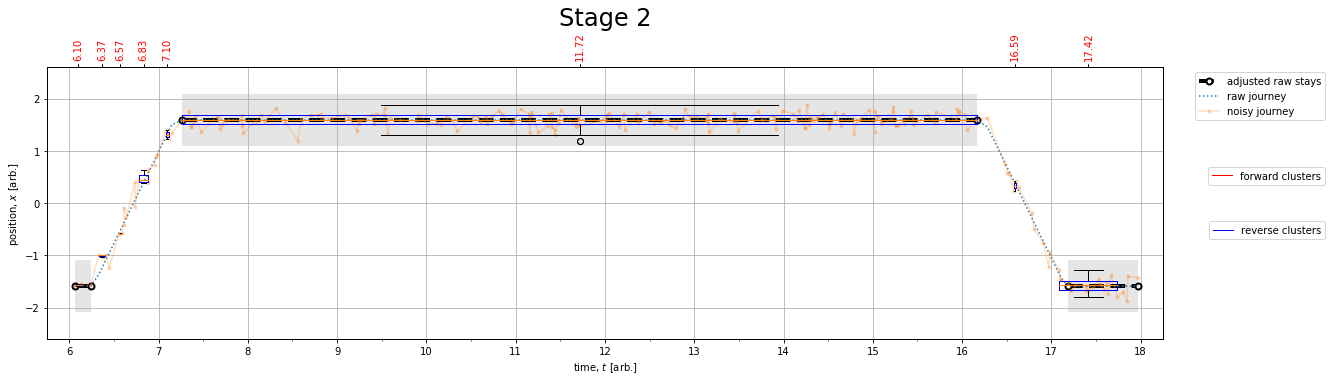

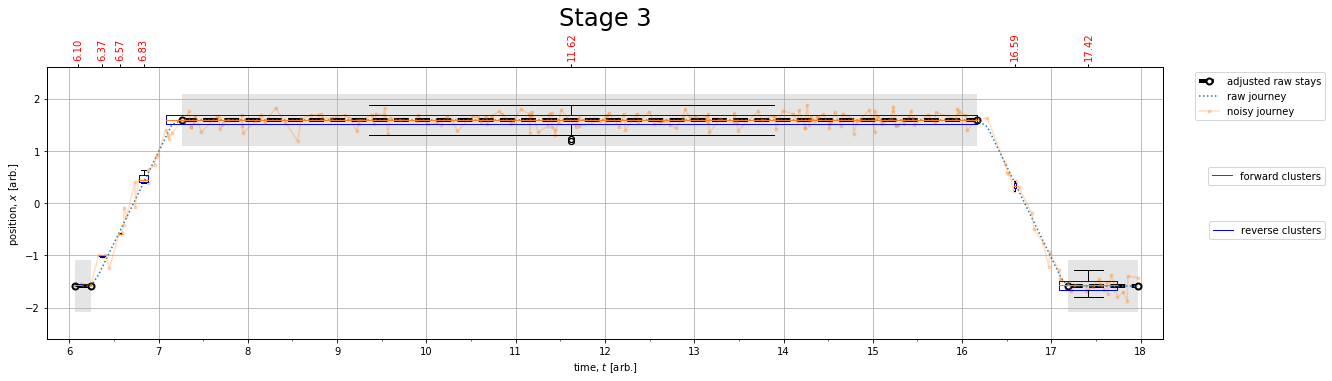

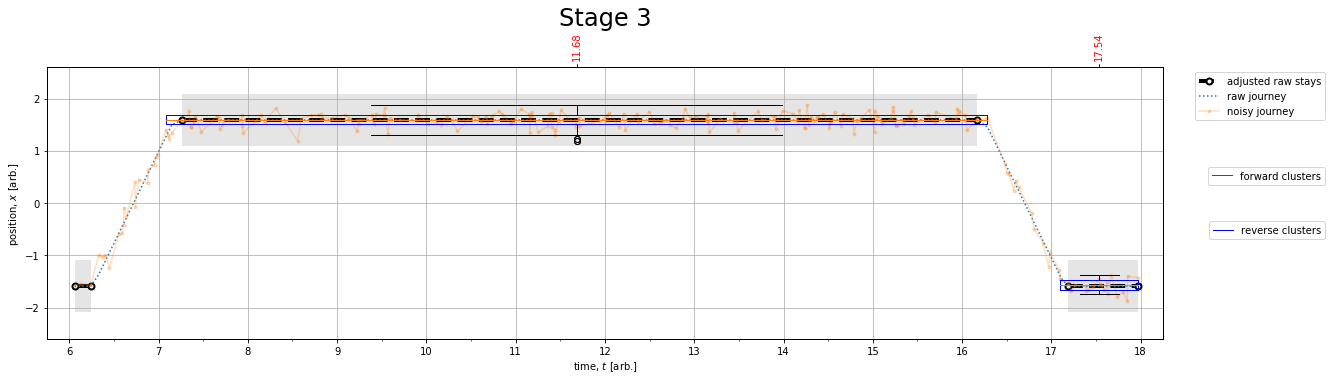

In [441]:
ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, new_clusters_2, switch_indices(new_clusters_2, time_arr.shape[0]), configs)
ax.set_ylim([-2.6, 2.6])
ax.set_title("Stage 2", fontsize=24);

clusters_xxx = get_clusters_xxx(time_arr, noise_arr, dist_thresh, time_thresh)

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_xxx, switch_indices(clusters_xxx, time_arr.shape[0]), configs)
ax.set_ylim([-2.6, 2.6])
ax.set_title("Stage 3", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, ext_clusters_2m, switch_indices(ext_clusters_2m, time_arr.shape[0]), configs)
ax.set_ylim([-2.6, 2.6])
ax.set_title("Stage 3", fontsize=24);

In [ ]:
lens = []
precs = []
recs = []

width=6
total = width*width*(2*width+1)
i = 0
for x_dist in rand_range(0.52,5.0, width):
    for mid_len in rand_range(0.2, 10, width):
        for shift in rand_range(-10, 10, 2*width+1):

            if np.random.randint(0,2,1):
                stays = get3(x_dist, mid_len, shift)
            else:
                stays = get3e(x_dist, mid_len, shift)    

            continuation = True
            while continuation:
                try:
                    #print(1)
                    time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)

                    print(2)
                    clusters = get_clusters_xx(time_arr, noise_arr, dist_thresh, time_thresh)
                    #clusters_rev = get_clusters_xx(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)

                    print(3)
                    new_clusters = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
                    #new_clusters_rev = merge_clusters(time_arr[::-1], noise_arr[::-1], clusters_rev, dist_thresh, time_thresh)

                    print(4)
                    new_clusters_2 = merge_clusters_2(time_arr, noise_arr, new_clusters, dist_thresh, time_thresh)
                    #new_clusters_rev_2 = merge_clusters_2(time_arr[::-1], noise_arr[::-1], new_clusters_rev, dist_thresh, time_thresh)

                    print(5)
                    ext_clusters     = get_extended_clusters(time_arr, noise_arr, new_clusters_2, time_thresh)
                    #ext_clusters_rev = get_extended_clusters(time_arr, noise_arr, switch_indices(new_clusters_rev_2, time_arr.shape[0]), time_thresh)
                    
                    print(6)
                    ext_clusters2 = separate_clusters(ext_clusters, ext_clusters)
                    #ext_clusters_rev2 = separate_clusters(ext_clusters_rev, ext_clusters_rev)
                       
                    print(7)
                    ext_clusters_2m = merge_clusters_2(time_arr, noise_arr, ext_clusters2, dist_thresh, time_thresh)
                    #ext_clusters_rev_2m = merge_clusters_2(time_arr, noise_arr, ext_clusters_rev2, dist_thresh, time_thresh)

                    print(8)
                    ext_clusters_2m = [sorted(c) for c in ext_clusters_2m]
                    #ext_clusters_rev_2m = [sorted(c) for c in ext_clusters_rev_2m]

                    continuation = False
                except:
                    pass

            prec, rec, conmat = eval_synth_data(segments, time_arr, ext_clusters_2m)
            #print(f"{len(ext_clusters_2m):4d} clusters:", subcluster_lengths(ext_clusters_2m))
            #print(f"\tp = {prec:6.3f}")
            #print(f"\tr = { rec:6.3f}")
            lens.append(len(ext_clusters_2m))
            precs.append(prec)
            recs.append(rec)
            if i % (width*width) == 0:
                print(f"{i:4d} of {total:5d}")
            i+=1
            None;

In [ ]:
plt.scatter(precs, recs)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.grid();

In [ ]:
plt.plot(lens)

In [ ]:
plt.hist(lens,bins=range(max(lens)+1), rwidth=0.95, align='left', density=True)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({"l":lens, "p":precs, "r":recs})

In [ ]:
df[df['l']==2].describe(percentiles=np.arange(0,1.0,0.1))

In [ ]:
df[df['l']==2].describe(percentiles=np.arange(0,1.0,0.1))

In [ ]:
df[df['l']==2].describe(percentiles=np.arange(0,1.0,0.1))

In [ ]:
print('1')
clusters = get_clusters_xx(time_arr, noise_arr, dist_thresh, time_thresh)
clusters_rev = get_clusters_xx(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)

prec, rec, conmat = eval_synth_data(segments, time_arr, clusters)
print('forward')
print("\t", len(clusters), 'clusters:', subcluster_lengths(clusters))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters_rev)
print('backward')
print("\t", len(clusters_rev), 'clusters:', subcluster_lengths(clusters_rev))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)

print()

print('2')

new_clusters = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
new_clusters_rev = merge_clusters(time_arr[::-1], noise_arr[::-1], clusters_rev, dist_thresh, time_thresh)

prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters)
print('forward')
print("\t", len(new_clusters), 'clusters:', subcluster_lengths(new_clusters))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters_rev)
print('backward')
print("\t", len(new_clusters_rev), 'clusters:', subcluster_lengths(new_clusters_rev))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)

print()

print('3')

new_clusters_2 = merge_clusters_2(time_arr, noise_arr, new_clusters, dist_thresh, time_thresh)
new_clusters_rev_2 = merge_clusters_2(time_arr[::-1], noise_arr[::-1], new_clusters_rev, dist_thresh, time_thresh)

#new_clusters_2 = merge_clusters_2(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
#new_clusters_rev_2 = merge_clusters_2(time_arr[::-1], noise_arr[::-1], clusters, dist_thresh, time_thresh)

prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters_2)
print('forward')
print("\t", len(new_clusters_2), 'clusters:', subcluster_lengths(new_clusters_2))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters_rev_2)
print('backward')
print("\t", len(new_clusters_rev_2), 'clusters:', subcluster_lengths(new_clusters_rev_2))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)

print('4')

ext_clusters     = get_extended_clusters(time_arr, noise_arr, new_clusters_2, time_thresh)
ext_clusters_rev = get_extended_clusters(time_arr, noise_arr, switch_indices(new_clusters_rev_2, time_arr.shape[0]), time_thresh)

prec, rec, conmat = eval_synth_data(segments, time_arr, ext_clusters)
print('forward')
print("\t", len(ext_clusters), 'clusters:', subcluster_lengths(ext_clusters))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)
prec, rec, conmat = eval_synth_data(segments, time_arr, ext_clusters_rev)
print('backward')
print("\t", len(ext_clusters_rev), 'clusters:', subcluster_lengths(ext_clusters_rev))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)


print('5')

print_clusts(ext_clusters);


ext_clusters2 = separate_clusters(ext_clusters, ext_clusters)
ext_clusters_rev2 = separate_clusters(ext_clusters_rev, ext_clusters_rev)

print_clusts(ext_clusters2);

ext_clusters_2m = merge_clusters_2(time_arr, noise_arr, ext_clusters2, dist_thresh, time_thresh)
ext_clusters_rev_2m = merge_clusters_2(time_arr, noise_arr, ext_clusters_rev2, dist_thresh, time_thresh)

ext_clusters_2m = [sorted(c) for c in ext_clusters_2m]
ext_clusters_rev_2m = [sorted(c) for c in ext_clusters_rev_2m]

print_ctdiff(ext_clusters_2m);
print_ctdiff(ext_clusters_rev_2m);


prec, rec, conmat = eval_synth_data(segments, time_arr, ext_clusters_2m)
print('forward')
print("\t", len(ext_clusters_2m), 'clusters:', subcluster_lengths(ext_clusters_2m))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)
prec, rec, conmat = eval_synth_data(segments, time_arr, ext_clusters_rev_2m)
print('backward')
print("\t", len(ext_clusters_rev_2m), 'clusters:', subcluster_lengths(ext_clusters_rev_2m))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)
#'''
None;

In [ ]:
ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters, clusters_rev, configs)
ax.set_ylim([-2.6, 2.6]);
ax.set_title("Stage 1", fontsize=24)

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, new_clusters, new_clusters_rev, configs)
ax.set_ylim([-2.6, 2.6])
ax.set_title("Stage 2", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, new_clusters_2, new_clusters_rev_2, configs)
ax.set_ylim([-2.6, 2.6])
ax.set_title("Stage 3", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, ext_clusters, switch_indices(ext_clusters_rev, time_arr.shape[0]), configs)
ax.set_ylim([-2.6, 2.6])
ax.set_title("Stage 4", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, ext_clusters_2m, switch_indices(ext_clusters_rev_2m, time_arr.shape[0]), configs)
ax.set_ylim([-2.6, 2.6])
ax.set_title("Stage 5", fontsize=24);

## Testing 2

In [ ]:
def separate_clusters_x(clusters1, clusters2):

    new_clusts = []
    m = 0
    while m < len(clusters1):
        c1 = clusters1[m]
        n = 0
        sc1 = set(c1)
        new_clust = []
        while n < len(clusters2):
            '''
            if m == n:
                n+=1
                continue
            '''    
            c2 = clusters2[n]
            
            print(f"{m:4d}: [{c1[0]:4d},{c1[-1]:4d}] and [{c2[0]:4d},{c2[-1]:4d}]")
            
            if inter_bounds(c1,c2):
                sc2 = set(c2)
                c = sorted(list(sc1.intersection(sc2)))
                new_clust.extend(c)
                print('yes')
            else:
                pass
            
            n+=1
        
        if len(new_clust)>0:
            new_clusts.append(new_clust)
        m+=1
        
    return new_clusts

In [ ]:
from helper__gaps import get_gap_dist
def merge_clusters_3(t_arr, x_arr, clusters, dist_thresh, time_thresh, min_speed=3.5, verbose=False):
    """
    Iteratively merge clusters in a a list according to criteria regarding the gaps between them
    """
    
    new_clusters = clusters.copy()
    
    gaps = [inter_bounds(c1,c2) for c1, c2 in zip(new_clusters[:-1],new_clusters[1:])]
    if verbose: print(gaps)
    while any(gaps):
        
        dists = [get_gap_dist(x_arr,c1,c2) for c1, c2 in zip(new_clusters[:-1],new_clusters[1:])]

        gaps_add = np.array([100*int(not g) for g in gaps])
        dists_add = np.array(dists)+gaps_add

        min_index = np.argmin(dists_add)
        
        if verbose: print(gaps, "\n", [f"{d:5.3f}" for d in dists], "\n", min_index)
        
        new_clusters = merge_cluster_pair(new_clusters, min_index).copy()
        
        gaps = [inter_bounds(c1,c2) for c1, c2 in zip(new_clusters[:-1],new_clusters[1:])]        

    if verbose: print(gaps)
    
    return new_clusters

In [ ]:
mext_clusters = merge_clusters_3(time_arr, noise_arr, ext_clusters, dist_thresh, time_thresh, 3.5, True);

In [ ]:
prec, rec, conmat = eval_synth_data(segments, time_arr, mext_clusters)
print("\t", len(mext_clusters), 'clusters:', subcluster_lengths(mext_clusters))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)

ax = plot_cluster_boxplots_x(time_arr, raw_arr, noise_arr, t_segs, x_segs, mext_clusters, configs)
ax.set_ylim([-2.6, 2.6]);

In [ ]:
iqr_mext_clusters = []
for c in mext_clusters:
    mask = get_iqr_mask(noise_arr[c], c)[0].tolist()
    iqr_mext_clusters.append(mask)
    print(mask[0],mask[-1])

In [ ]:
prec, rec, conmat = eval_synth_data(segments, time_arr, iqr_mext_clusters)
print("\t", len(iqr_mext_clusters), 'clusters:', subcluster_lengths(iqr_mext_clusters))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)

ax = plot_cluster_boxplots_x(time_arr, raw_arr, noise_arr, t_segs, x_segs, iqr_mext_clusters, configs)
ax.set_ylim([-2.6, 2.6]);

## Testing

In [ ]:
event_frac = rand_range(0.01,0.001, 1)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

x_dist = rand_range(0.52,5.0, 10)[0]
mid_len = rand_range(0.2, 10, 10)[0]
shift = rand_range(-10, 10, 21)[0]

print(x_dist, mid_len, shift)
if np.random.randint(0,2,1):
    stays = get3(x_dist, mid_len, shift)
else:
    stays = get3e(x_dist, mid_len, shift)    
    
continuation = True
while continuation:
    try:
        time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
        continuation = False
    except:
        pass
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, dist_thresh);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.set_xlim([5.75,18.25]);

In [ ]:
print('1')
clusters = get_clusters_xx(time_arr, noise_arr, dist_thresh, time_thresh)
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters)
print('forward')
print("\t", len(clusters), 'clusters:', subcluster_lengths(clusters))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)

print()

print('2')

new_clusters = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters)
print('forward')
print("\t", len(new_clusters), 'clusters:', subcluster_lengths(new_clusters))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)

print()

print('3')

new_clusters_2 = merge_clusters_2(time_arr, noise_arr, new_clusters, dist_thresh, time_thresh)
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters_2)
print('forward')
print("\t", len(new_clusters_2), 'clusters:', subcluster_lengths(new_clusters_2))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)

print()

print('4')

ext_clusters     = get_extended_clusters(time_arr, noise_arr, new_clusters_2, time_thresh)
prec, rec, conmat = eval_synth_data(segments, time_arr, ext_clusters)
print('forward')
print("\t", len(ext_clusters), 'clusters:', subcluster_lengths(ext_clusters))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)

print()

print('5')

ext_clusters2 = separate_clusters(ext_clusters, ext_clusters)
ext_clusters_2m = merge_clusters_2(time_arr, noise_arr, ext_clusters2, dist_thresh, time_thresh)
ext_clusters_2m = [sorted(c) for c in ext_clusters_2m]

prec, rec, conmat = eval_synth_data(segments, time_arr, ext_clusters_2m)
print('forward')
print("\t", len(ext_clusters_2m), 'clusters:', subcluster_lengths(ext_clusters_2m))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)


print()

print('6')

mext_clusters = merge_clusters_3(time_arr, noise_arr, ext_clusters, dist_thresh, time_thresh, 3.5, False);
prec, rec, conmat = eval_synth_data(segments, time_arr, mext_clusters)
print("\t", len(mext_clusters), 'clusters:', subcluster_lengths(mext_clusters))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)

print()

print('7')

iqr_mext_clusters = []
for c in mext_clusters:
    mask = get_iqr_mask(noise_arr[c], c)[0].tolist()
    iqr_mext_clusters.append(mask)
    print(mask[0],mask[-1])
    
prec, rec, conmat = eval_synth_data(segments, time_arr, iqr_mext_clusters)
print("\t", len(iqr_mext_clusters), 'clusters:', subcluster_lengths(iqr_mext_clusters))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)
None;

In [ ]:
ax = plot_cluster_boxplots_x(time_arr, raw_arr, noise_arr, t_segs, x_segs, iqr_mext_clusters, configs)
ax.set_ylim([-2.6, 2.6]);

In [ ]:
ext_clusters = [sorted(c) for c in ext_clusters]
print_clusts(ext_clusters);

print()

ext_clusters2 = separate_clusters_x(ext_clusters, ext_clusters)

'''print()

ext_clusters2 = [sorted(c) for c in ext_clusters2]
print_clusts(ext_clusters2);

print()

ext_clusters_2m = merge_clusters_2(time_arr, noise_arr, ext_clusters2, dist_thresh, time_thresh)

ext_clusters_2m = [sorted(c) for c in ext_clusters_2m]
print_clusts(ext_clusters_2m)

print()

ext_clusters_2m = [sorted(c) for c in ext_clusters_2m]

print_clusts(ext_clusters_2m);
'''
None;

In [ ]:
ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, ext_clusters_2m, switch_indices(ext_clusters_rev_2m, time_arr.shape[0]), configs)
ax.set_ylim([-2.6, 2.6])
ax.set_title("Stage 5", fontsize=24);

In [ ]:
final_sep_clusts = separate_clusters(ext_clusters_rev_2m, ext_clusters_2m);

prec, rec, conmat = eval_synth_data(segments, time_arr, final_sep_clusts)
print("\t", len(final_sep_clusts), 'clusters:', subcluster_lengths(final_sep_clusts))
print(f"\t{prec:6.3f}")
print(f"\t{ rec:6.3f}")
#print("\t", conmat)

ax = plot_cluster_boxplots_x(time_arr, raw_arr, noise_arr, t_segs, x_segs, final_sep_clusts, configs)
ax.set_ylim([-2.6, 2.6]);

In [ ]:
print_clusts(ext_clusters);

In [ ]:
print_clusts(ext_clusters_2m);

In [ ]:
ax = plot_cluster_boxplots_x(time_arr, raw_arr, noise_arr, t_segs, x_segs, ext_clusters, configs)
ax.set_ylim([-2.6, 2.6]);

ax = plot_cluster_boxplots_x(time_arr, raw_arr, noise_arr, t_segs, x_segs, ext_clusters_2m, configs)
ax.set_ylim([-2.6, 2.6]);

In [ ]:
ax = plot_cluster_boxplots_x(time_arr, raw_arr, noise_arr, t_segs, x_segs, ext_clusters, configs)
ax.set_ylim([-2.6, 2.6]);

In [ ]:
ax = plot_cluster_boxplots_x(time_arr, raw_arr, noise_arr, t_segs, x_segs, ext_clusters_rev, configs)
ax.set_ylim([-2.6, 2.6]);

In [ ]:
print_clusts(switch_indices(new_clusters_rev_2, time_arr.shape[0]));

In [ ]:
print_clusts(new_clusters_rev_2);

In [ ]:
ax = plot_cluster_boxplots_x(time_arr[::-1], raw_arr[::-1], noise_arr[::-1], t_segs[::-1], x_segs[::-1], clusters_rev, configs)
ax.set_ylim([-2.6, 2.6]);

In [ ]:
ax = plot_cluster_boxplots_x(time_arr, raw_arr, noise_arr, t_segs, x_segs, switch_indices(clusters_rev, time_arr.shape[0]), configs)
ax.set_ylim([-2.6, 2.6]);

In [ ]:
def plot_cluster_boxplots_x(t_arr, x_arr, nx_arr, t_segs, x_segs, clusters, configs, verbose=False):

    from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes
    from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev    

    dist_thresh = configs['dist_thresh']
    
    ax = plot_trajectory(t_arr, x_arr, nx_arr, None, None, dist_thresh);
    #add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

    ax.set_xlim([5.75,18.25])

    bp_data, labels, positions, widths = get_boxplot_quants(t_arr, nx_arr, clusters)

    if verbose: print(positions)
    if verbose: print(widths)
    axt = ax.twiny()
    _ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

    for label in axt.get_xticklabels():
        label.set_rotation(90)
    axt.set_xticklabels(labels, visible=True, color='red')


    axt.set_xlim(ax.get_xlim())
    axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);
    
    return ax

In [ ]:
print_cstuff = lambda cluster_list : [print(f"[{time_arr[c[0]]:6.3f},{time_arr[c[-1]]:6.3f}], {abs(time_arr[c[0]]-time_arr[c[-1]]):6.3f}, {0.5*(time_arr[c[0]]+time_arr[c[-1]]):6.3f}") for c in cluster_list]

In [ ]:
print_cstuff(ext_clusters);

In [ ]:
_ = get_extended_clusters(time_arr, noise_arr, new_clusters_rev_2, time_thresh, True)

In [ ]:
time_arr[222]

In [ ]:
ext_clusters_rev = get_extended_clusters(time_arr, noise_arr, new_clusters_rev_2, time_thresh)

In [ ]:
ext_clusters_rev[2]

In [ ]:
# Get only those indices which occur in both for-/back-wards sets;
# --> store to a single set of clusters
# NOTE: the bias is towards the backwards set of clusters
total_mindices = []
for c in new_clusters_2:
    # get those indices which define the IQR of a cluster
    mask = get_iqr_mask(noise_arr[c], c, 0, True)
    # ... and save them flattened
    total_mindices.extend(mask[0].tolist())

total_mindices_rev = []
final_clusters_rev = []
for c in new_clusters_rev_2:
    # get those indices which define the IQR of a cluster    
    mask = get_iqr_mask(noise_arr[c], c, 0, True)
    
    cluster = list(set(mask[0].tolist()).intersection(set(total_mindices)))
    total_mindices_rev.extend(cluster)
    if len(cluster)>5:        
        final_clusters_rev.append(sorted(cluster))
total_mindices_rev = sorted(total_mindices_rev)

In [ ]:
# Get only those indices which occur in both for-/back-wards sets;
# --> store to a single set of clusters
# NOTE: the bias is towards the backwards set of clusters
total_mindices_rev = []
for c in new_clusters_rev_2:
    # get those indices which define the IQR of a cluster
    mask = get_iqr_mask(noise_arr[c], c, 0, True)
    # ... and save them flattened
    total_mindices_rev.extend(mask[0].tolist())

total_mindices = []
final_clusters = []
for c in new_clusters_2:
    # get those indices which define the IQR of a cluster    
    mask = get_iqr_mask(noise_arr[c], c, 0, True)
    
    cluster = list(set(mask[0].tolist()).intersection(set(total_mindices_rev)))
    total_mindices.extend(cluster)
    if len(cluster)>5:
        final_clusters.append(sorted(cluster))
total_mindices_rev = sorted(total_mindices)

In [ ]:
len(final_clusters), len(final_clusters_rev)

In [ ]:
for c1,c2 in zip(final_clusters,final_clusters_rev):
    
    if (len(c1)>1) and (len(c2)>1):
        print(f"c1: {len(c1):4d}: [{c1[0]:4d},{c1[-1]:4d}] and c2: {len(c2):4d}: [{c2[0]:4d},{c2[-1]:4d}]")
    elif (len(c1)>1):
        print(f"c1: {len(c1):4d}: [{c1[0]:4d},{c1[-1]:4d}] and c2: {len(c2):4d}: [    ,    ]")
    elif (len(c2)>1):
        print(f"c1: {len(c1):4d}: [    ,    ] and c2: {len(c2):4d}: [{c2[0]:4d},{c2[-1]:4d}]")
    else:
        print(f"c1: {len(c1):4d}: [    ,    ] and c2: {len(c2):4d}: [    ,    ]")
        

In [ ]:
from helper__3stays_v3_scripts import get_extended_clusters

In [ ]:
final_extended_clusters = get_extended_clusters(time_arr, noise_arr, final_clusters, time_thresh, True)

In [ ]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

for c in final_extended_clusters:

    ax.plot(time_arr[c], noise_arr[c], "k+", markersize=10, markerfacecolor='k')

ax.set_xlim([5.5,18.25])
#ax.set_xlim([8.5,15.5]);

In [ ]:
prec, rec, conmat = eval_synth_data(segments, time_arr, final_extended_clusters)
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

In [ ]:
from helper__3stays_v3_scripts import eval_synth_data_clusters

In [ ]:
from synthetic_data.trajectory import get_stay_indices, get_adjusted_stays
from sklearn.metrics import precision_score, recall_score, confusion_matrix
    
    
expected_nr_of_stays = int((len(segments)+1)/2)

fig, ax = plt.subplots(figsize=[20,8])
color='C0'

colors = ['C0','C1','C2']

for n in range(0,len(segments),2):
    
    true_indices = get_stay_indices(get_adjusted_stays(segments[n:n+1], time_arr), time_arr)[0]    
    print(n, true_indices[0], true_indices[-1])
    
    nn = int(n/2)
    clust = final_extended_clusters[nn]
    print(nn, clust[0], clust[-1])    
    
    pair = [min(true_indices[0],clust[0]), max(true_indices[-1],clust[-1])]
    print(pair)
    
    true_labels = np.zeros(time_arr.shape)
    true_labels[true_indices[0]:true_indices[1]+1] = 1
        
        
    pred_labels = np.zeros(time_arr.shape)
    pred_labels[clust[0]:clust[-1]+1] = 1      
    
 
    prec = precision_score(true_labels, pred_labels)
    rec  = recall_score(true_labels, pred_labels)        
    
    color = colors[nn]
    ax.plot(true_labels, 'o', markersize=10, color=color, markerfacecolor='None', alpha=0.5)
    ax.plot(pred_labels, '.', color=color)

    print(prec, rec)
    #break

plt.grid()    

In [ ]:
from helper__3stays_v3_scripts import get_no_overlap

In [ ]:
ultimate_clusters = get_no_overlap(time_arr, final_extended_clusters.copy())

In [ ]:
get_uniqs = lambda clusts: [print(len(c), len(set(c))) for c in clusts]

In [ ]:
_ = get_uniqs(final_clusters)

In [ ]:
_ = get_uniqs(final_extended_clusters)

In [ ]:
_ = get_uniqs(ultimate_clusters)

In [ ]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

for c in final_extended_clusters:

    ax.plot(time_arr[c], noise_arr[c], "k+", markersize=10, markerfacecolor='k')


for c in ultimate_clusters:

    ax.plot(time_arr[c], noise_arr[c], "ko", markersize=4, markerfacecolor='k')

ax.set_xlim([5.5,18.25])
#ax.set_xlim([8.5,15.5]);

In [ ]:
prec, rec, conmat = eval_synth_data(segments, time_arr, ultimate_clusters)
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

---

## Full run

In [ ]:
from helper__3stays_v3_scripts import cluster_method

In [ ]:
fin_clusters = cluster_method(time_arr, noise_arr, dist_thresh, time_thresh, segments, False)

In [ ]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

for c in fin_clusters:

    ax.plot(time_arr[c], noise_arr[c], "k+", markersize=10, markerfacecolor='k')

ax.set_xlim([5.5,18.25])
#ax.set_xlim([8.5,15.5]);
ax.set_ylim([-1.6, 0.6]);

In [ ]:
def get_segments_scores(segments, clusters, verbose=False):
    
    expected_nr_of_stays = int((len(segments)+1)/2)

    precs = []
    recs = []
    for n in range(0,len(segments),2):

        true_indices = get_stay_indices(get_adjusted_stays(segments[n:n+1], time_arr), time_arr)[0]    
        #if verbose: print(n, true_indices[0], true_indices[-1])

        nn = int(n/2)
        clust = clusters[nn]
        #if verbose: print(nn, clust[0], clust[-1])    

        pair = [min(true_indices[0],clust[0]), max(true_indices[-1],clust[-1])]
        #if verbose: print(pair)

        true_labels = np.zeros(time_arr.shape)
        true_labels[true_indices[0]:true_indices[1]+1] = 1


        pred_labels = np.zeros(time_arr.shape)
        pred_labels[clust[0]:clust[-1]+1] = 1      

        precs.append(precision_score(true_labels, pred_labels))
        recs.append(recall_score(true_labels, pred_labels)        )

        if verbose: print(f"Cluster {nn:3d}, precision: {precs[-1]:6.3f}; recall: {recs[-1]:6.3f}")

    if verbose: print(f"\nFinals: \n\tmin. precision: {min(precs):6.3f}; min. recall: {min(recs):6.3f}")
    if verbose: print(f"\tavg. precision: {sum(precs)/len(precs):6.3f}; avg. recall: {sum(recs)/len(recs):6.3f}")
    
    return precs, recs

In [ ]:
_ = get_segments_scores(segments, fin_clusters, True)

In [ ]:
rand_range = lambda min_, max_, size: (max_-min_)*np.random.random_sample(size=size) + min_

In [ ]:
rand_range(0.01,0.001,1)[0]

In [ ]:
precs = []
recs = []
i = 0
break_cond = False
for x_dist in rand_range(0.51,5.0, 10):
    
    event_frac = rand_range(0.01,0.001, 1)[0]
    duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

    configs = {
        'time_thresh':1/6,
        'dist_thresh':0.5,
        'event_frac':event_frac,
        'duplicate_frac':duplicate_frac,    
        'noise_min':0.02,
        'noise_max':0.15
    }
    for mid_len in rand_range(0.2, 10, 10):
        
        # 
        try:
            stays = get3(x_dist, mid_len)

            time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
            t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))
        except:
            print("Bad synth. data")
            continue
            
        try:
            fin_clusters = cluster_method(time_arr, noise_arr, dist_thresh, time_thresh, False)
            

            if (len(fin_clusters) == int((len(segments)+1)/2)) and (len(fin_clusters) > 0):
                precs,recs = get_segments_scores(segments, fin_clusters, False)
            
                precs.append(sum(precs)/len(precs))
                recs.append(sum(recs)/len(recs))  
                print("yes", i, len(fin_clusters), int((len(segments)+1)/2))
            else:
                
                precs.append(0.0)
                recs.append(0.0)
                print("no1", i, len(fin_clusters), int((len(segments)+1)/2))
                ax_set_title = 'Missing'
                break_cond = True
                break             
            
        except:
            print("no2", i, len(fin_clusters), int((len(segments)+1)/2))
            precs.append(None)
            recs.append(None)     
            break_cond = True
            ax_set_title = 'Bad'
            break              
        
        print("broken loop", break_cond)
        if break_cond: 
            print("breaking")
            break
        
        i+=1
        
    print("broken loop", break_cond)
    if break_cond: 
        print("breaking\n\nLast clusters")
        
        clusters = get_clusters_x(time_arr, noise_arr, dist_thresh, time_thresh)
        clusters_rev = get_clusters_x(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)

        prec, rec, conmat = eval_synth_data(segments, time_arr, clusters)
        print('forward')

        print("\t", len(clusters), 'clusters:', subcluster_lengths(clusters))
        print(f"\t{prec:6.3f}")
        print(f"\t{ rec:6.3f}")
        #print("\t", conmat)
        print()
        prec, rec, conmat = eval_synth_data(segments, time_arr, clusters_rev)
        print('backward')
        print("\t", len(clusters_rev), 'clusters:', subcluster_lengths(clusters_rev))
        print(f"\t{prec:6.3f}")
        print(f"\t{ rec:6.3f}")
        #print("\t", conmat)


        new_clusters = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
        new_clusters_rev = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, time_thresh)

        prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters)
        print('forward')
        print("\t", len(new_clusters), 'clusters:', subcluster_lengths(new_clusters))
        print(f"\t{prec:6.3f}")
        print(f"\t{ rec:6.3f}")
        #print("\t", conmat)
        print()
        prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters_rev)
        print('backward')
        print("\t", len(new_clusters_rev), 'clusters:', subcluster_lengths(new_clusters_rev))
        print(f"\t{prec:6.3f}")
        print(f"\t{ rec:6.3f}")
        #print("\t", conmat)


        new_clusters_2 = merge_clusters_2(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
        new_clusters_rev_2 = merge_clusters_2(time_arr[::-1], noise_arr[::-1], clusters, dist_thresh, time_thresh)

        prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters_2)
        print('forward')
        print("\t", len(new_clusters_2), 'clusters:', subcluster_lengths(new_clusters_2))
        print(f"\t{prec:6.3f}")
        print(f"\t{ rec:6.3f}")
        #print("\t", conmat)
        print()
        prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters_rev_2)
        print('backward')
        print("\t", len(new_clusters_rev_2), 'clusters:', subcluster_lengths(new_clusters_rev_2))
        print(f"\t{prec:6.3f}")
        print(f"\t{ rec:6.3f}")
        #print("\t", conmat)       
        ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters, clusters_rev, configs)
        ax.set_ylim([-2.6, 2.6])
        ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, new_clusters, new_clusters_rev, configs);
        ax.set_ylim([-2.6, 2.6])
        ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, new_clusters_2, new_clusters_rev_2, configs);
        ax.set_ylim([-2.6, 2.6])
        
        ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
        add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

        for c in fin_clusters:

            ax.plot(time_arr[c], noise_arr[c], "k+", markersize=10, markerfacecolor='k')

        ax.set_xlim([5.5,18.25])
        ax.set_ylim([-2.6, 2.6])     
        ax.set_title(ax_set_title)
        break            
        
        

In [ ]:
len(precs)

In [ ]:
plt.scatter(precs,recs, alpha=0.6)
plt.ylim(-0.01,1.05)
plt.xlim(-0.01,1.05)
plt.grid();

In [ ]:
np.sqrt(1000)

In [ ]:
ax = plot_trajectory(time_arr, None, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

for c in fin_clusters:

    ax.plot(time_arr[c], noise_arr[c], "k+", markersize=10, markerfacecolor='k')

ax.set_xlim([5.5,18.25])
#ax.set_xlim([8.5,15.5]);